In [1]:
import os
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random,math
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5

In [2]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# train_pred = pd.read_csv('./simple_xgboost_cv.csv', index_col='TransactionID')
# test_pred = pd.read_csv('./simple_xgboost_pred.csv', index_col='TransactionID')
# test_pred['pred'] = (test_pred['pred1'] + test_pred['pred2'] + test_pred['pred3'] )/3
# del test_pred['pred1'],test_pred['pred2'],test_pred['pred3']

# train_f1 = pd.read_csv('../input/f1_train.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]
# test_f1 = pd.read_csv('../input/f1_test.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]



sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

CPU times: user 47.6 s, sys: 4.36 s, total: 52 s
Wall time: 53.4 s


In [3]:
# train_f5 = pd.read_csv('../input/f5_train2.csv', index_col='TransactionID').iloc[:,:3]
# test_f5 = pd.read_csv('../input/f5_test2.csv', index_col='TransactionID').iloc[:,:3]
train_f6 = pd.read_csv('../input/f5_train3.csv', index_col='TransactionID').iloc[:,:3]
test_f6 = pd.read_csv('../input/f5_test3.csv', index_col='TransactionID').iloc[:,:3]

In [4]:
import pickle
f = open('mail_columns_ProNE_32.pickle','rb')
f_prone = pickle.loads(f.read()) 
f.close()
del f_prone['TransactionID']
print(f_prone.shape)

f_prone_train = f_prone.iloc[:train_transaction.shape[0]]
f_prone_train.index = train_transaction.index
f_prone_test = f_prone.iloc[train_transaction.shape[0]:]
f_prone_test.index = test_transaction.index
f_prone_col = f_prone.columns
print(f_prone.columns)

(1097231, 32)
Index(['mail_columns_ProNE_Emb_0', 'mail_columns_ProNE_Emb_1',
       'mail_columns_ProNE_Emb_2', 'mail_columns_ProNE_Emb_3',
       'mail_columns_ProNE_Emb_4', 'mail_columns_ProNE_Emb_5',
       'mail_columns_ProNE_Emb_6', 'mail_columns_ProNE_Emb_7',
       'mail_columns_ProNE_Emb_8', 'mail_columns_ProNE_Emb_9',
       'mail_columns_ProNE_Emb_10', 'mail_columns_ProNE_Emb_11',
       'mail_columns_ProNE_Emb_12', 'mail_columns_ProNE_Emb_13',
       'mail_columns_ProNE_Emb_14', 'mail_columns_ProNE_Emb_15',
       'mail_columns_ProNE_Emb_16', 'mail_columns_ProNE_Emb_17',
       'mail_columns_ProNE_Emb_18', 'mail_columns_ProNE_Emb_19',
       'mail_columns_ProNE_Emb_20', 'mail_columns_ProNE_Emb_21',
       'mail_columns_ProNE_Emb_22', 'mail_columns_ProNE_Emb_23',
       'mail_columns_ProNE_Emb_24', 'mail_columns_ProNE_Emb_25',
       'mail_columns_ProNE_Emb_26', 'mail_columns_ProNE_Emb_27',
       'mail_columns_ProNE_Emb_28', 'mail_columns_ProNE_Emb_29',
       'mail_columns_

In [5]:
train_transaction['TransactionDT2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))
test_transaction['TransactionDT2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))

f = open('emb/index_feature.pkl','rb')
index_feature = pickle.loads(f.read())
feature_index = {}
for k,v in index_feature.items():
    feature_index[v] = k
    print(k,v)

embeddings_matrix = np.load("emb/spectral.emb.npy")
print(embeddings_matrix.shape)
embeddings_dict = {}
for i in range((embeddings_matrix.shape[0])):
    embeddings_dict[feature_index[i]] = embeddings_matrix[i,:]

size = 8
for col in "P_emaildomain".split(","):
    print(col)
    for i in range(size):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*size)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*size)[i])       
        #         print(train_transaction["w2v_"+col+str(i)])         

for col in "card1,card2,addr1".split(","):
    for i in range(size):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*size)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*size)[i])

# for col in "TransactionDT".split(","):
#     print(col)
#     for i in range(24):
#         train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].map(lambda x:(x)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT"+"_"+str(int(x)),[0]*24)[i])
#         test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].map(lambda x:(x)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT"+"_"+str(int(x)),[0]*24)[i])
#         train_transaction["w2v_"+col+"2_"+str(i)] = train_transaction[col].map(lambda x:(x+3600*24*3.5)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT2"+"_"+str(int(x)),[0]*24)[i])
#         test_transaction["w2v_"+col+"2_"+str(i)] = test_transaction[col].map(lambda x:(x+3600*24*3.5)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT2"+"_"+str(int(x)),[0]*24)[i])


TransactionDT_0 0
TransactionDT2_0 1
uid_13926_nan_150.0_discover 2
addr1_315 3
P_emaildomain_-1 4
amt_68.5 5
uid_2755_404.0_150.0_mastercard 6
addr1_325 7
P_emaildomain_gmail.com 8
amt_29.0 9
uid_4663_490.0_150.0_visa 10
addr1_330 11
P_emaildomain_outlook.com 12
amt_59.0 13
uid_18132_567.0_150.0_mastercard 14
addr1_476 15
P_emaildomain_yahoo.com 16
amt_50.0 17
uid_4497_514.0_150.0_mastercard 18
addr1_420 19
uid_5937_555.0_150.0_visa 20
addr1_272 21
amt_49.0 22
uid_12308_360.0_150.0_visa 23
addr1_126 24
amt_159.0 25
uid_12695_490.0_150.0_visa 26
P_emaildomain_mail.com 27
amt_422.5 28
uid_2803_100.0_150.0_visa 29
addr1_337 30
P_emaildomain_anonymous.com 31
amt_15.0 32
uid_17399_111.0_150.0_mastercard 33
addr1_204 34
amt_117.0 35
uid_16496_352.0_117.0_mastercard 36
addr1_-1 37
amt_75.887 38
uid_4461_375.0_185.0_mastercard 39
P_emaildomain_hotmail.com 40
amt_16.495 41
uid_3786_418.0_150.0_visa 42
P_emaildomain_verizon.net 43
uid_12866_303.0_150.0_visa 44
P_emaildomain_aol.com 45
amt_40.0 

uid_2773_nan_150.0_visa 1014
amt_97.95 1015
amt_156.99 1016
uid_10856_268.0_150.0_visa 1017
uid_16485_174.0_150.0_visa 1018
uid_13052_254.0_150.0_visa 1019
amt_221.99 1020
uid_8439_127.0_150.0_mastercard 1021
uid_12970_nan_150.0_visa 1022
uid_12116_404.0_150.0_mastercard 1023
uid_12260_236.0_150.0_visa 1024
uid_17422_321.0_150.0_visa 1025
uid_13833_111.0_150.0_visa 1026
amt_540.0 1027
amt_166.0 1028
uid_14649_548.0_150.0_visa 1029
amt_235.0 1030
amt_26.99 1031
uid_5620_489.0_150.0_mastercard 1032
uid_13108_215.0_150.0_visa 1033
uid_7299_111.0_150.0_mastercard 1034
amt_418.78 1035
amt_59.58 1036
amt_142.0 1037
uid_15314_111.0_150.0_mastercard 1038
uid_2021_177.0_185.0_mastercard 1039
amt_77.579 1040
amt_68.51 1041
uid_16494_454.0_150.0_visa 1042
uid_10680_373.0_150.0_visa 1043
amt_218.0 1044
amt_287.5 1045
amt_50.08 1046
uid_18031_543.0_150.0_mastercard 1047
uid_18375_174.0_150.0_visa 1048
uid_7638_174.0_150.0_visa 1049
uid_4553_268.0_150.0_mastercard 1050
uid_17990_275.0_150.0_masterca

uid_10756_390.0_150.0_mastercard 2142
amt_304.7 2143
amt_205.0 2144
uid_17517_369.0_150.0_mastercard 2145
uid_8058_174.0_150.0_visa 2146
amt_7.19 2147
uid_3324_555.0_150.0_visa 2148
amt_17.522000000000002 2149
amt_362.95 2150
amt_46.99 2151
amt_28.941 2152
uid_3916_341.0_185.0_visa 2153
uid_4717_321.0_150.0_visa 2154
uid_2773_512.0_150.0_visa 2155
uid_1506_555.0_150.0_mastercard 2156
uid_5761_555.0_150.0_mastercard 2157
amt_23.25 2158
uid_7757_514.0_150.0_mastercard 2159
amt_233.0 2160
amt_29.061999999999998 2161
uid_17208_543.0_150.0_mastercard 2162
amt_484.95 2163
uid_13120_330.0_150.0_visa 2164
amt_183.45 2165
amt_71.65 2166
amt_21.147 2167
uid_11942_570.0_150.0_visa 2168
amt_32.023 2169
uid_12690_512.0_150.0_mastercard 2170
uid_12783_501.0_150.0_visa 2171
uid_10505_567.0_150.0_mastercard 2172
amt_118.02 2173
uid_4476_574.0_150.0_visa 2174
uid_7170_514.0_150.0_mastercard 2175
uid_13073_555.0_150.0_mastercard 2176
amt_639.0 2177
addr1_491 2178
uid_1738_225.0_150.0_mastercard 2179
uid

uid_3150_555.0_150.0_visa 3393
amt_21.026 3394
uid_11680_555.0_150.0_visa 3395
uid_1073_310.0_150.0_mastercard 3396
uid_3250_412.0_150.0_visa 3397
amt_74.99 3398
uid_15854_555.0_213.0_visa 3399
amt_329.67 3400
amt_839.04 3401
uid_3957_233.0_150.0_visa 3402
amt_8.821 3403
amt_39.99 3404
uid_10907_555.0_150.0_visa 3405
uid_2113_555.0_150.0_visa 3406
uid_4526_571.0_150.0_visa 3407
uid_9705_555.0_150.0_mastercard 3408
amt_305.97 3409
uid_1011_543.0_150.0_mastercard 3410
amt_21.57 3411
amt_312.9 3412
uid_9039_310.0_150.0_mastercard 3413
amt_599.0 3414
uid_14793_555.0_150.0_visa 3415
amt_411.0 3416
uid_10063_555.0_150.0_visa 3417
uid_17870_369.0_150.0_mastercard 3418
amt_78.788 3419
amt_33.0 3420
uid_12891_543.0_150.0_mastercard 3421
amt_9.244 3422
uid_13324_122.0_150.0_mastercard 3423
uid_6453_555.0_150.0_visa 3424
uid_1532_127.0_150.0_mastercard 3425
uid_5451_555.0_150.0_visa 3426
amt_62.233000000000004 3427
uid_5836_399.0_150.0_american express 3428
amt_1082.47 3429
amt_147.0 3430
uid_694

amt_283.0 4356
uid_1617_555.0_150.0_visa 4357
amt_29.605999999999998 4358
amt_471.44 4359
uid_13810_194.0_150.0_mastercard 4360
uid_2569_174.0_150.0_visa 4361
uid_1290_555.0_150.0_visa 4362
amt_93.19 4363
amt_86.76299999999999 4364
amt_109.965 4365
uid_12056_143.0_150.0_visa 4366
uid_9677_225.0_150.0_mastercard 4367
amt_258.598 4368
uid_7447_399.0_150.0_american express 4369
uid_9343_369.0_150.0_mastercard 4370
amt_552.65 4371
uid_16991_555.0_150.0_visa 4372
uid_3577_418.0_150.0_visa 4373
uid_8698_168.0_144.0_visa 4374
uid_1113_nan_150.0_visa 4375
amt_449.95 4376
uid_15765_514.0_150.0_mastercard 4377
amt_33.957 4378
uid_17926_124.0_150.0_visa 4379
uid_14357_555.0_150.0_visa 4380
uid_18373_383.0_150.0_visa 4381
uid_8400_111.0_150.0_visa 4382
uid_13240_210.0_150.0_visa 4383
amt_814.52 4384
amt_389.95 4385
amt_39.213 4386
uid_12923_225.0_150.0_mastercard 4387
uid_13676_555.0_150.0_visa 4388
uid_7963_225.0_150.0_mastercard 4389
uid_4956_240.0_150.0_visa 4390
amt_292.92 4391
uid_7062_481.0_

amt_399.05 5556
uid_5670_310.0_150.0_mastercard 5557
uid_10332_555.0_150.0_visa 5558
amt_92.805 5559
uid_15874_555.0_185.0_mastercard 5560
amt_32.507 5561
amt_43.865 5562
uid_17662_543.0_150.0_mastercard 5563
uid_18030_122.0_150.0_mastercard 5564
uid_9995_479.0_150.0_visa 5565
amt_285.0 5566
amt_407.2 5567
amt_615.95 5568
uid_13393_555.0_222.0_visa 5569
amt_174.01 5570
amt_72.32300000000001 5571
amt_673.95 5572
amt_31.781 5573
amt_23.08 5574
uid_5431_555.0_150.0_visa 5575
amt_179.87 5576
uid_1313_555.0_150.0_visa 5577
amt_93.34899999999999 5578
uid_15738_555.0_150.0_visa 5579
uid_16901_425.0_150.0_mastercard 5580
uid_11980_555.0_150.0_visa 5581
uid_15540_555.0_220.0_visa 5582
uid_11019_277.0_144.0_visa 5583
uid_7407_258.0_150.0_visa 5584
uid_9684_514.0_150.0_mastercard 5585
uid_13978_525.0_150.0_visa 5586
uid_2948_310.0_150.0_mastercard 5587
amt_15.275 5588
amt_74.48 5589
uid_15479_520.0_150.0_american express 5590
uid_3574_232.0_150.0_visa 5591
uid_8033_383.0_150.0_visa 5592
addr1_198

addr1_111 6979
amt_17.548 6980
uid_4453_nan_150.0_visa 6981
uid_7874_225.0_150.0_mastercard 6982
amt_111.353 6983
amt_13.992 6984
uid_1081_447.0_150.0_visa 6985
uid_2438_348.0_150.0_mastercard 6986
amt_22.504 6987
amt_6.996 6988
amt_262.01 6989
uid_16645_555.0_150.0_visa 6990
amt_21.688000000000002 6991
amt_20.463 6992
uid_13331_555.0_195.0_mastercard 6993
amt_202.88400000000001 6994
uid_5226_420.0_150.0_mastercard 6995
uid_5371_512.0_150.0_mastercard 6996
amt_37.429 6997
uid_7195_225.0_150.0_mastercard 6998
amt_11.543 6999
amt_25.069000000000003 7000
uid_7484_209.0_150.0_mastercard 7001
amt_265.63 7002
amt_12.825999999999999 7003
uid_10981_310.0_150.0_mastercard 7004
amt_870.18 7005
amt_769.99 7006
uid_6907_103.0_185.0_visa 7007
amt_10.027999999999999 7008
amt_20.522 7009
uid_14281_435.0_150.0_visa 7010
amt_81.154 7011
amt_93.572 7012
uid_9756_390.0_150.0_mastercard 7013
uid_17138_399.0_150.0_american express 7014
uid_2181_555.0_150.0_visa 7015
amt_432.5 7016
amt_12.36 7017
amt_10.96 

amt_68.094 8146
uid_2843_562.0_150.0_mastercard 8147
uid_4356_555.0_150.0_visa 8148
uid_9988_555.0_150.0_visa 8149
amt_334.49 8150
uid_5643_543.0_150.0_mastercard 8151
amt_53.053000000000004 8152
uid_12178_543.0_150.0_mastercard 8153
uid_13995_399.0_150.0_american express 8154
uid_2757_555.0_150.0_visa 8155
uid_8804_555.0_150.0_visa 8156
amt_315.5 8157
uid_11527_360.0_150.0_mastercard 8158
uid_3172_555.0_150.0_visa 8159
amt_7.928999999999999 8160
uid_9472_399.0_150.0_american express 8161
amt_21.921 8162
uid_9215_475.0_150.0_visa 8163
uid_16511_179.0_106.0_visa 8164
amt_74.158 8165
uid_9704_321.0_150.0_visa 8166
uid_10083_555.0_150.0_mastercard 8167
amt_153.95 8168
amt_3.8480000000000003 8169
uid_6396_369.0_150.0_mastercard 8170
amt_27.99 8171
uid_2290_555.0_150.0_visa 8172
uid_10697_555.0_150.0_visa 8173
uid_13819_555.0_150.0_mastercard 8174
amt_26.06 8175
addr1_146 8176
amt_74.682 8177
uid_9732_399.0_150.0_american express 8178
amt_73.34100000000001 8179
amt_19.531 8180
uid_12555_555

amt_383.5 9979
amt_392.16 9980
uid_15445_555.0_150.0_visa 9981
uid_2177_512.0_150.0_mastercard 9982
amt_70.018 9983
uid_5135_555.0_150.0_visa 9984
uid_18220_399.0_150.0_american express 9985
uid_16475_310.0_150.0_mastercard 9986
amt_834.95 9987
uid_12195_555.0_117.0_mastercard 9988
uid_6705_127.0_150.0_mastercard 9989
amt_72.875 9990
uid_8443_555.0_133.0_mastercard 9991
uid_15264_127.0_150.0_mastercard 9992
uid_1608_555.0_150.0_visa 9993
amt_194.68 9994
amt_365.42 9995
uid_11692_555.0_150.0_visa 9996
uid_7630_225.0_150.0_mastercard 9997
amt_94.55 9998
addr1_156 9999
amt_156.65200000000002 10000
uid_4958_399.0_150.0_american express 10001
amt_622.95 10002
uid_11613_225.0_150.0_mastercard 10003
uid_13725_310.0_150.0_mastercard 10004
amt_3027.13 10005
uid_8274_478.0_150.0_visa 10006
uid_4662_298.0_150.0_visa 10007
amt_2890.29 10008
amt_25.25 10009
uid_7337_174.0_150.0_visa 10010
uid_13743_555.0_150.0_visa 10011
uid_14926_528.0_150.0_visa 10012
uid_2067_420.0_150.0_mastercard 10013
uid_159

uid_6038_555.0_150.0_visa 11946
uid_3385_352.0_117.0_visa 11947
uid_14075_532.0_150.0_mastercard 11948
amt_10.6 11949
uid_14370_496.0_150.0_mastercard 11950
amt_38.653 11951
uid_5231_555.0_144.0_mastercard 11952
amt_71.709 11953
uid_18271_399.0_150.0_american express 11954
amt_15.040999999999999 11955
amt_1644.95 11956
uid_12481_555.0_150.0_visa 11957
uid_7485_490.0_150.0_visa 11958
amt_45.008 11959
amt_28.5 11960
amt_119.632 11961
uid_16880_555.0_150.0_visa 11962
amt_15.974 11963
uid_5045_555.0_150.0_visa 11964
amt_90.598 11965
amt_205.45 11966
uid_14223_382.0_150.0_visa 11967
uid_11393_216.0_150.0_american express 11968
amt_68.105 11969
uid_11940_399.0_150.0_american express 11970
uid_3668_555.0_150.0_visa 11971
amt_380.116 11972
amt_35.388000000000005 11973
uid_16461_408.0_185.0_mastercard 11974
uid_3257_399.0_150.0_american express 11975
uid_2381_399.0_150.0_american express 11976
amt_306.27 11977
amt_330.46 11978
uid_1812_555.0_117.0_visa 11979
amt_109.52 11980
uid_16722_399.0_150

amt_5.99 13478
amt_2583.95 13479
amt_408.3 13480
uid_14950_138.0_200.0_mastercard 13481
amt_76.373 13482
uid_7652_310.0_150.0_mastercard 13483
amt_44.599 13484
amt_10.440999999999999 13485
amt_47.223 13486
uid_14082_225.0_150.0_mastercard 13487
amt_93.74600000000001 13488
uid_16387_399.0_150.0_american express 13489
uid_16726_469.0_106.0_mastercard 13490
uid_5260_529.0_150.0_visa 13491
amt_312.43 13492
amt_770.95 13493
amt_30.956999999999997 13494
TransactionDT_3 13495
uid_9649_555.0_150.0_visa 13496
uid_17318_543.0_150.0_mastercard 13497
uid_16640_111.0_150.0_visa 13498
uid_13755_555.0_150.0_visa 13499
amt_5.3 13500
uid_5521_555.0_150.0_visa 13501
uid_1148_543.0_150.0_mastercard 13502
amt_82.611 13503
amt_95.146 13504
uid_8967_399.0_150.0_american express 13505
amt_1134.95 13506
uid_4341_514.0_150.0_mastercard 13507
uid_4965_529.0_150.0_visa 13508
amt_72.817 13509
uid_3929_555.0_150.0_visa 13510
amt_420.35 13511
uid_17765_512.0_150.0_mastercard 13512
amt_26.089000000000002 13513
amt_4

amt_1308.5 14442
amt_96.25299999999999 14443
uid_14796_555.0_150.0_visa 14444
amt_198.90900000000002 14445
amt_57.13399999999999 14446
uid_6623_470.0_150.0_mastercard 14447
amt_362.4 14448
amt_30.719 14449
uid_11447_480.0_150.0_mastercard 14450
uid_5233_555.0_150.0_visa 14451
uid_10731_555.0_150.0_visa 14452
uid_2694_399.0_150.0_american express 14453
amt_95.729 14454
uid_12861_399.0_150.0_american express 14455
amt_85.818 14456
uid_1121_555.0_180.0_visa 14457
uid_15583_555.0_229.0_visa 14458
uid_10916_512.0_150.0_mastercard 14459
uid_11284_399.0_150.0_american express 14460
uid_8090_543.0_150.0_mastercard 14461
amt_204.68599999999998 14462
amt_335.58 14463
amt_155.92 14464
amt_117.475 14465
amt_74.741 14466
amt_68.847 14467
uid_4800_125.0_150.0_american express 14468
amt_185.74400000000003 14469
uid_12447_555.0_150.0_visa 14470
uid_4888_418.0_150.0_visa 14471
amt_273.777 14472
uid_12587_nan_150.0_visa 14473
amt_1569.97 14474
amt_84.59299999999999 14475
uid_17811_225.0_150.0_mastercard

uid_1428_360.0_150.0_visa 16228
amt_472.88 16229
amt_1324.31 16230
amt_100.5 16231
amt_695.7 16232
uid_2756_555.0_150.0_visa 16233
uid_15055_480.0_150.0_mastercard 16234
amt_32.945 16235
amt_163.007 16236
amt_161.84 16237
uid_14908_555.0_150.0_visa 16238
amt_130.8 16239
amt_2516.95 16240
amt_393.67 16241
uid_8562_555.0_150.0_visa 16242
uid_15736_321.0_150.0_visa 16243
uid_10620_555.0_150.0_visa 16244
uid_10591_201.0_150.0_visa 16245
amt_752.0 16246
amt_48.681000000000004 16247
amt_589.65 16248
amt_389.94 16249
uid_1470_310.0_150.0_mastercard 16250
uid_6949_555.0_150.0_visa 16251
amt_929.27 16252
amt_366.5 16253
uid_6055_174.0_150.0_mastercard 16254
amt_738.65 16255
uid_9027_555.0_148.0_mastercard 16256
amt_109.604 16257
uid_14765_nan_213.0_visa 16258
amt_2352.95 16259
uid_4594_399.0_150.0_american express 16260
uid_10899_555.0_134.0_visa 16261
uid_1547_543.0_150.0_mastercard 16262
uid_10797_225.0_150.0_mastercard 16263
uid_7673_561.0_150.0_visa 16264
amt_331.37 16265
amt_577.88 16266
u

amt_1997.95 17977
amt_235.63 17978
amt_831.85 17979
uid_16702_480.0_150.0_mastercard 17980
amt_1435.95 17981
amt_422.2 17982
amt_417.12 17983
amt_540.37 17984
amt_120.65 17985
amt_95.464 17986
amt_239.87 17987
amt_489.97 17988
uid_4869_555.0_150.0_visa 17989
amt_1111.06 17990
uid_15171_555.0_141.0_mastercard 17991
amt_262.1 17992
amt_96.068 17993
amt_81.48 17994
amt_449.52 17995
amt_1933.51 17996
uid_6861_399.0_150.0_american express 17997
uid_11456_321.0_150.0_visa 17998
amt_460.94 17999
amt_1271.0 18000
amt_608.95 18001
amt_91.71 18002
uid_17692_555.0_150.0_visa 18003
amt_100.479 18004
amt_4.4110000000000005 18005
amt_956.95 18006
uid_12482_480.0_150.0_mastercard 18007
amt_2354.66 18008
uid_7138_555.0_197.0_visa 18009
amt_13.934000000000001 18010
amt_167.26 18011
amt_426.83 18012
uid_3692_555.0_166.0_visa 18013
amt_296.93 18014
amt_313.95 18015
amt_722.95 18016
amt_64.46 18017
amt_632.91 18018
amt_1084.95 18019
amt_557.84 18020
uid_2368_390.0_150.0_mastercard 18021
uid_3735_nan_150.0

amt_152.26 19477
amt_504.45 19478
amt_213.2 19479
uid_8665_212.0_150.0_visa 19480
amt_469.34 19481
uid_8929_321.0_150.0_visa 19482
uid_15947_390.0_150.0_mastercard 19483
amt_512.87 19484
uid_7416_527.0_150.0_visa 19485
amt_1198.09 19486
uid_10980_567.0_150.0_visa 19487
amt_158.14 19488
uid_8266_555.0_150.0_visa 19489
uid_17117_555.0_150.0_visa 19490
amt_205.25 19491
uid_5757_555.0_150.0_visa 19492
amt_546.03 19493
amt_509.93 19494
amt_1710.7 19495
amt_2768.83 19496
amt_53.99 19497
amt_1825.95 19498
amt_702.7 19499
amt_1502.7 19500
amt_256.8 19501
amt_336.58 19502
amt_1085.6 19503
amt_444.47 19504
amt_200.18 19505
amt_279.73 19506
uid_14090_555.0_150.0_visa 19507
amt_356.45 19508
uid_14088_321.0_150.0_visa 19509
amt_409.87 19510
uid_8506_555.0_150.0_visa 19511
amt_285.82 19512
amt_204.25 19513
amt_588.29 19514
amt_609.85 19515
amt_1511.95 19516
amt_711.55 19517
uid_17173_321.0_150.0_visa 19518
uid_10138_555.0_148.0_mastercard 19519
uid_7335_310.0_150.0_mastercard 19520
uid_2550_161.0_15

amt_2293.11 20977
amt_56.553000000000004 20978
uid_12445_192.0_150.0_visa 20979
amt_140.174 20980
uid_13010_555.0_150.0_visa 20981
amt_410.18 20982
amt_56.13 20983
amt_1027.95 20984
uid_8873_555.0_150.0_visa 20985
amt_173.52599999999998 20986
amt_11.902999999999999 20987
amt_385.53 20988
uid_1651_321.0_150.0_visa 20989
amt_273.18 20990
amt_653.84 20991
amt_244.5 20992
amt_231.97 20993
addr1_435 20994
amt_36.159 20995
amt_1042.06 20996
uid_8379_369.0_150.0_mastercard 20997
uid_15386_555.0_150.0_visa 20998
uid_12409_543.0_150.0_mastercard 20999
amt_22.295 21000
amt_46.644 21001
uid_17684_555.0_150.0_visa 21002
uid_9544_555.0_134.0_visa 21003
amt_124.163 21004
amt_221.96 21005
uid_14530_237.0_150.0_mastercard 21006
uid_8935_277.0_144.0_visa 21007
amt_2499.47 21008
amt_1508.5 21009
amt_102.895 21010
amt_139.11700000000002 21011
uid_9019_321.0_150.0_visa 21012
amt_57.097 21013
uid_8046_480.0_150.0_mastercard 21014
uid_1708_555.0_100.0_mastercard 21015
amt_16.176 21016
uid_6551_555.0_135.0_v

amt_78.063 22330
amt_1014.75 22331
uid_12680_543.0_150.0_mastercard 22332
amt_33.044000000000004 22333
uid_1315_478.0_150.0_visa 22334
amt_441.19 22335
amt_110.992 22336
amt_211.39 22337
amt_485.17 22338
amt_19.512999999999998 22339
amt_79.76 22340
amt_1082.78 22341
amt_408.18 22342
amt_487.47 22343
amt_1118.95 22344
amt_17.2 22345
amt_1082.71 22346
uid_4477_390.0_150.0_mastercard 22347
amt_5.438 22348
amt_2574.47 22349
amt_193.98 22350
uid_16486_555.0_152.0_mastercard 22351
amt_73.954 22352
amt_50.368 22353
uid_15477_302.0_150.0_visa 22354
uid_2416_498.0_150.0_mastercard 22355
amt_233.93 22356
uid_10205_555.0_150.0_visa 22357
amt_945.15 22358
amt_345.44 22359
amt_401.71 22360
amt_17.461 22361
amt_304.84 22362
amt_2549.2 22363
amt_421.71 22364
uid_4676_467.0_150.0_visa 22365
amt_345.49 22366
uid_17715_555.0_150.0_visa 22367
amt_157.47 22368
uid_8284_555.0_150.0_visa 22369
amt_94.678 22370
amt_675.27 22371
amt_108.47 22372
uid_11731_555.0_150.0_visa 22373
amt_63.622 22374
uid_2386_520.0

uid_14163_321.0_150.0_visa 23976
amt_2524.13 23977
amt_246.84 23978
amt_63.562 23979
amt_759.44 23980
amt_124.88799999999999 23981
amt_67.913 23982
amt_48.39 23983
amt_2.9610000000000003 23984
amt_63.501999999999995 23985
uid_11427_555.0_150.0_visa 23986
amt_56.431999999999995 23987
amt_852.94 23988
amt_15.96 23989
amt_618.86 23990
uid_14497_512.0_150.0_mastercard 23991
uid_15542_543.0_150.0_mastercard 23992
amt_220.45 23993
amt_301.31 23994
uid_15558_512.0_150.0_mastercard 23995
amt_1831.97 23996
amt_97.51799999999999 23997
uid_15818_394.0_150.0_visa 23998
amt_362.51 23999
amt_884.54 24000
amt_53.45 24001
amt_272.5 24002
amt_3144.97 24003
amt_55.35 24004
amt_435.31 24005
amt_563.74 24006
amt_79.2 24007
uid_13195_555.0_150.0_visa 24008
amt_364.68 24009
amt_61.025 24010
uid_13897_390.0_150.0_mastercard 24011
amt_42.114 24012
amt_62.776 24013
amt_41.34 24014
uid_8758_555.0_182.0_mastercard 24015
amt_42.958999999999996 24016
uid_17894_555.0_102.0_visa 24017
amt_65.314 24018
amt_66.31 2401

amt_497.47 24976
amt_377.47 24977
amt_510.32 24978
uid_16989_543.0_150.0_mastercard 24979
uid_13081_225.0_150.0_mastercard 24980
uid_3293_555.0_188.0_visa 24981
amt_340.31 24982
uid_3467_555.0_144.0_visa 24983
uid_16051_512.0_150.0_mastercard 24984
uid_5817_321.0_150.0_visa 24985
uid_8336_555.0_119.0_visa 24986
amt_105.25200000000001 24987
amt_101.264 24988
uid_11793_143.0_150.0_visa 24989
amt_961.0 24990
amt_1499.4 24991
uid_14413_555.0_144.0_american express 24992
amt_208.45 24993
amt_201.28 24994
amt_49.49 24995
uid_4939_555.0_150.0_visa 24996
amt_431.45 24997
amt_214.99 24998
amt_590.47 24999
amt_2951.95 25000
uid_2932_529.0_150.0_mastercard 25001
uid_15605_555.0_150.0_visa 25002
amt_103.681 25003
amt_2400.9 25004
amt_1085.79 25005
uid_7498_124.0_150.0_visa 25006
amt_244.72 25007
amt_373.42 25008
uid_5470_555.0_150.0_visa 25009
amt_391.27 25010
uid_2992_555.0_150.0_visa 25011
amt_1852.21 25012
amt_297.92 25013
amt_764.97 25014
amt_220.171 25015
amt_319.41 25016
amt_659.78 25017
amt

amt_558.46 26476
amt_2206.95 26477
amt_243.4 26478
amt_493.28 26479
amt_709.37 26480
amt_1613.43 26481
amt_687.11 26482
amt_1765.17 26483
amt_2000.35 26484
uid_1885_512.0_150.0_mastercard 26485
uid_14800_225.0_150.0_mastercard 26486
amt_413.5 26487
amt_86.521 26488
amt_487.6 26489
amt_3582.95 26490
uid_5508_nan_150.0_mastercard 26491
uid_2873_447.0_150.0_visa 26492
amt_454.56 26493
uid_1504_543.0_150.0_mastercard 26494
amt_385.23 26495
uid_10637_512.0_150.0_visa 26496
amt_1470.5 26497
amt_72.262 26498
amt_224.64 26499
amt_123.99 26500
amt_137.516 26501
uid_10485_543.0_150.0_mastercard 26502
amt_1249.01 26503
amt_926.69 26504
amt_2328.95 26505
amt_2028.63 26506
uid_15924_555.0_223.0_mastercard 26507
amt_2537.59 26508
amt_916.04 26509
amt_141.658 26510
amt_401.0 26511
amt_2446.99 26512
uid_15351_390.0_150.0_mastercard 26513
amt_92.20100000000001 26514
amt_1298.87 26515
amt_76.431 26516
amt_829.95 26517
amt_316.65 26518
amt_75.797 26519
amt_660.95 26520
amt_592.47 26521
amt_74.98100000000

uid_2431_555.0_150.0_visa 28226
amt_1547.0 28227
uid_8016_555.0_182.0_visa 28228
uid_8091_569.0_117.0_visa 28229
amt_821.59 28230
amt_96.189 28231
amt_124.949 28232
amt_2968.95 28233
amt_1716.97 28234
amt_570.0 28235
amt_1756.95 28236
amt_1609.2 28237
amt_387.33 28238
amt_391.18 28239
amt_1435.0 28240
amt_82.01899999999999 28241
amt_481.5 28242
amt_2841.95 28243
amt_464.22 28244
amt_391.6 28245
amt_182.468 28246
uid_12995_520.0_150.0_american express 28247
amt_492.07 28248
amt_731.66 28249
uid_14986_512.0_150.0_mastercard 28250
amt_418.71 28251
amt_5543.23 28252
amt_307.56 28253
amt_378.6 28254
uid_13412_555.0_150.0_visa 28255
amt_409.81 28256
uid_8897_555.0_150.0_visa 28257
amt_1169.19 28258
amt_88.334 28259
amt_196.123 28260
amt_401.29 28261
amt_706.37 28262
amt_76.55199999999999 28263
amt_230.5 28264
amt_32.07 28265
amt_680.19 28266
amt_928.47 28267
uid_11646_512.0_150.0_mastercard 28268
amt_422.53 28269
amt_1946.8 28270
amt_2126.95 28271
amt_190.27 28272
amt_823.05 28273
amt_1354.7

amt_11.005 29725
amt_34.429 29726
amt_32.215 29727
amt_237.19 29728
amt_77.465 29729
amt_48.692 29730
amt_53.672 29731
amt_23.793000000000003 29732
amt_17.079 29733
amt_46.602 29734
amt_15.493 29735
amt_18.628 29736
amt_56.806999999999995 29737
amt_20.903000000000002 29738
amt_47.95399999999999 29739
amt_8.115 29740
amt_4.243 29741
uid_6173_555.0_102.0_visa 29742
amt_16.539 29743
amt_3.627 29744
amt_3.997 29745
uid_1886_555.0_210.0_visa 29746
amt_64.493 29747
amt_24.346 29748
amt_118.226 29749
amt_80.108 29750
amt_276.5 29751
amt_7.255 29752
amt_61.972 29753
amt_14.263 29754
amt_16.292 29755
uid_11039_142.0_185.0_mastercard 29756
amt_19.551 29757
amt_108.76 29758
amt_46.049 29759
uid_2784_225.0_150.0_mastercard 29760
amt_6.886 29761
amt_115.337 29762
amt_13.034 29763
amt_35.412 29764
amt_2957.95 29765
amt_44.63399999999999 29766
amt_16.784000000000002 29767
amt_351.35 29768
uid_14138_555.0_150.0_visa 29769
amt_29.203000000000003 29770
amt_277.45 29771
amt_16.354 29772
amt_384.8 29773
a

amt_12.849 31289
amt_2.23 31290
amt_11.45 31291
amt_82.62899999999999 31292
uid_9601_555.0_183.0_visa 31293
amt_33.260999999999996 31294
amt_506.87 31295
amt_457.99 31296
amt_10.284 31297
uid_10959_545.0_185.0_visa 31298
amt_472.53 31299
amt_904.0 31300
uid_11549_543.0_150.0_mastercard 31301
amt_313.85 31302
amt_486.85 31303
uid_18287_nan_150.0_american express 31304
uid_4026_399.0_150.0_american express 31305
amt_53.488 31306
amt_368.56 31307
amt_95.417 31308
amt_87.056 31309
amt_1768.1 31310
amt_471.64 31311
uid_16223_555.0_150.0_visa 31312
amt_265.72 31313
amt_584.34 31314
amt_2016.1 31315
amt_4.303999999999999 31316
amt_2.459 31317
uid_3420_555.0_150.0_visa 31318
amt_125.911 31319
uid_13594_555.0_137.0_visa 31320
amt_1627.38 31321
amt_110.664 31322
uid_13216_555.0_150.0_visa 31323
amt_395.62 31324
amt_56.193000000000005 31325
amt_84.228 31326
amt_105.831 31327
addr1_237 31328
amt_249.916 31329
amt_47.155 31330
uid_10163_489.0_150.0_mastercard 31331
amt_595.33 31332
amt_1615.55 3133

amt_1919.95 32725
amt_469.94 32726
amt_2121.0 32727
amt_481.69 32728
uid_13635_517.0_150.0_mastercard 32729
amt_1865.31 32730
amt_1194.72 32731
amt_143.05 32732
amt_409.47 32733
amt_580.31 32734
amt_1246.99 32735
amt_0.364 32736
amt_1696.07 32737
amt_57.73 32738
uid_17640_225.0_150.0_mastercard 32739
amt_104.86 32740
amt_500.46 32741
amt_106.48299999999999 32742
amt_289.25 32743
amt_1094.95 32744
amt_594.96 32745
amt_408.28 32746
amt_355.81 32747
amt_750.95 32748
amt_1890.81 32749
amt_498.04 32750
amt_227.71 32751
amt_2825.85 32752
amt_1091.55 32753
amt_474.33 32754
amt_2185.71 32755
uid_15529_555.0_147.0_visa 32756
uid_3833_555.0_166.0_visa 32757
amt_347.0 32758
amt_926.45 32759
amt_678.17 32760
amt_77.342 32761
amt_26.146 32762
amt_70.395 32763
amt_989.35 32764
amt_274.05 32765
uid_10813_399.0_150.0_american express 32766
amt_111.27 32767
amt_1643.47 32768
amt_39.716 32769
amt_780.48 32770
uid_13949_555.0_150.0_mastercard 32771
uid_8152_481.0_150.0_visa 32772
amt_425.29 32773
amt_233

amt_54.776 34107
amt_51.797 34108
amt_127.509 34109
amt_5.489 34110
amt_8.764 34111
amt_70.456 34112
amt_781.7 34113
amt_76.297 34114
uid_7818_555.0_188.0_visa 34115
uid_8220_555.0_185.0_mastercard 34116
amt_1544.14 34117
amt_6.534 34118
uid_17015_nan_150.0_american express 34119
uid_17695_127.0_150.0_mastercard 34120
amt_154.25 34121
amt_73.315 34122
amt_1071.61 34123
amt_126.03399999999999 34124
uid_17426_nan_150.0_visa 34125
amt_1542.26 34126
amt_3100.44 34127
amt_562.88 34128
amt_309.57 34129
amt_37.36 34130
amt_84.83200000000001 34131
amt_352.69 34132
amt_581.06 34133
amt_119.456 34134
amt_3092.51 34135
uid_2190_555.0_150.0_visa 34136
amt_381.58 34137
uid_17323_555.0_131.0_mastercard 34138
uid_13835_399.0_150.0_american express 34139
amt_2109.15 34140
amt_414.93 34141
amt_2191.29 34142
amt_71.624 34143
uid_4804_555.0_119.0_visa 34144
amt_578.47 34145
amt_18.203 34146
amt_26.741999999999997 34147
amt_584.88 34148
amt_780.38 34149
amt_1393.81 34150
amt_426.5 34151
amt_353.35 34152
a

amt_36.516999999999996 35561
amt_69.53399999999999 35562
uid_11658_555.0_141.0_visa 35563
uid_1840_555.0_141.0_mastercard 35564
amt_5.672999999999999 35565
amt_78.94 35566
TransactionDT2_26 35567
amt_22.287 35568
uid_2140_275.0_150.0_mastercard 35569
amt_299.52 35570
amt_28.315 35571
amt_58.928999999999995 35572
amt_17.528 35573
amt_487.24 35574
amt_2606.95 35575
uid_14448_555.0_150.0_mastercard 35576
amt_2406.95 35577
uid_10281_111.0_150.0_visa 35578
uid_13404_nan_150.0_visa 35579
amt_23.252 35580
amt_25.674 35581
uid_12022_555.0_188.0_mastercard 35582
uid_9733_369.0_150.0_mastercard 35583
amt_233.317 35584
amt_334.94300000000004 35585
amt_8.932 35586
amt_21.124000000000002 35587
uid_5187_555.0_150.0_mastercard 35588
uid_15126_554.0_150.0_visa 35589
amt_1.984 35590
amt_261.97 35591
uid_1511_555.0_150.0_visa 35592
amt_54.23 35593
uid_2570_555.0_150.0_visa 35594
uid_13362_512.0_150.0_mastercard 35595
uid_9115_555.0_188.0_visa 35596
amt_73.933 35597
amt_979.33 35598
amt_121.01 35599
amt_

amt_221.082 36972
amt_88.101 36973
amt_68.42699999999999 36974
amt_447.144 36975
amt_99.551 36976
TransactionDT2_33 36977
uid_14524_111.0_150.0_visa 36978
amt_893.95 36979
amt_338.38599999999997 36980
amt_348.74 36981
uid_4599_555.0_150.0_visa 36982
uid_5918_512.0_150.0_mastercard 36983
amt_2490.5 36984
uid_18198_555.0_150.0_visa 36985
amt_233.62 36986
uid_4044_302.0_150.0_visa 36987
amt_60.18899999999999 36988
amt_114.72200000000001 36989
uid_13130_555.0_150.0_visa 36990
uid_6655_555.0_150.0_visa 36991
uid_12263_321.0_150.0_visa 36992
amt_101.381 36993
uid_10607_555.0_119.0_mastercard 36994
uid_5092_138.0_200.0_mastercard 36995
uid_7843_554.0_150.0_mastercard 36996
uid_5621_348.0_150.0_visa 36997
amt_1059.0 36998
amt_156.405 36999
uid_5948_nan_150.0_visa 37000
uid_6149_426.0_150.0_visa 37001
uid_8123_555.0_150.0_visa 37002
amt_103.04 37003
uid_2030_543.0_150.0_mastercard 37004
amt_29.281 37005
uid_15409_nan_182.0_visa 37006
uid_1924_310.0_150.0_mastercard 37007
amt_98.552 37008
amt_9.

amt_29.549 38181
uid_4631_555.0_150.0_visa 38182
amt_12.954 38183
amt_119.579 38184
uid_11429_302.0_150.0_visa 38185
uid_10927_555.0_150.0_visa 38186
uid_10712_554.0_150.0_visa 38187
amt_29.551 38188
amt_42.434 38189
uid_9423_555.0_100.0_visa 38190
uid_11834_555.0_150.0_visa 38191
amt_69.7 38192
uid_10143_111.0_150.0_visa 38193
uid_7848_321.0_150.0_visa 38194
amt_133.535 38195
amt_2.476 38196
amt_114.66 38197
amt_0.325 38198
uid_13874_555.0_100.0_mastercard 38199
uid_8371_578.0_150.0_mastercard 38200
amt_4.224 38201
amt_3.7510000000000003 38202
amt_57.11600000000001 38203
amt_994.16 38204
amt_228.09099999999998 38205
amt_27.697 38206
amt_28.211 38207
uid_11950_555.0_166.0_visa 38208
amt_150.995 38209
amt_50.567 38210
uid_10424_439.0_144.0_mastercard 38211
amt_14.045 38212
amt_44.101000000000006 38213
amt_98.368 38214
amt_148.782 38215
uid_16687_nan_214.0_visa 38216
amt_243.83 38217
uid_13536_305.0_106.0_mastercard 38218
amt_984.97 38219
amt_604.87 38220
amt_833.08 38221
amt_456.91 3822

uid_2723_555.0_150.0_visa 39224
amt_514.12 39225
uid_6680_555.0_150.0_mastercard 39226
uid_5545_555.0_100.0_mastercard 39227
amt_53.53 39228
uid_5278_555.0_213.0_mastercard 39229
amt_407.77 39230
amt_568.22 39231
amt_50.001000000000005 39232
amt_16.05 39233
uid_15347_555.0_117.0_mastercard 39234
uid_7102_555.0_141.0_visa 39235
uid_14722_225.0_150.0_mastercard 39236
addr1_319 39237
uid_12771_302.0_150.0_visa 39238
amt_36.668 39239
uid_18029_555.0_150.0_visa 39240
amt_362.98 39241
amt_87.96 39242
amt_3098.39 39243
uid_7163_481.0_150.0_mastercard 39244
amt_311.2 39245
amt_896.11 39246
amt_488.71 39247
amt_231.41099999999997 39248
amt_620.01 39249
amt_40.755 39250
amt_182.688 39251
uid_9226_302.0_150.0_visa 39252
amt_1097.95 39253
uid_15967_125.0_150.0_american express 39254
uid_3196_555.0_150.0_visa 39255
amt_638.07 39256
uid_5900_555.0_150.0_visa 39257
amt_42.47 39258
uid_17682_555.0_150.0_visa 39259
amt_315.45 39260
amt_55.731 39261
uid_3777_555.0_210.0_mastercard 39262
amt_431.87 39263

uid_7830_555.0_150.0_visa 40473
amt_1440.3 40474
amt_14.667 40475
uid_14180_nan_150.0_visa 40476
uid_11126_321.0_150.0_visa 40477
amt_494.11 40478
amt_19.157 40479
uid_13912_540.0_106.0_visa 40480
uid_5274_555.0_189.0_visa 40481
amt_282.25 40482
amt_225.21 40483
amt_1677.37 40484
amt_443.62 40485
amt_106.67 40486
amt_602.57 40487
amt_242.58 40488
uid_5936_555.0_150.0_visa 40489
amt_1871.43 40490
uid_11113_555.0_196.0_mastercard 40491
amt_298.55 40492
amt_2267.85 40493
amt_2940.95 40494
uid_14125_399.0_150.0_american express 40495
amt_957.0 40496
amt_50.618 40497
amt_1595.61 40498
amt_129.661 40499
uid_13292_555.0_150.0_visa 40500
amt_1181.81 40501
uid_14953_332.0_150.0_visa 40502
amt_1569.95 40503
amt_2487.84 40504
amt_395.09 40505
amt_9.057 40506
amt_1185.89 40507
amt_952.37 40508
amt_413.43 40509
uid_5989_555.0_150.0_visa 40510
uid_5282_555.0_150.0_mastercard 40511
amt_300.268 40512
amt_13.585 40513
amt_2328.47 40514
amt_2201.0 40515
amt_64.984 40516
amt_722.81 40517
amt_80.354 40518

uid_8833_514.0_150.0_mastercard 41723
amt_291.54 41724
uid_2466_555.0_150.0_mastercard 41725
uid_2860_555.0_150.0_visa 41726
uid_14892_555.0_113.0_mastercard 41727
uid_17121_555.0_102.0_visa 41728
amt_285.18 41729
amt_111.89399999999999 41730
amt_4424.07 41731
uid_8063_399.0_150.0_american express 41732
amt_19.028 41733
amt_5.3420000000000005 41734
amt_1765.95 41735
uid_16197_555.0_150.0_visa 41736
amt_1018.57 41737
amt_122.09 41738
uid_17330_555.0_100.0_mastercard 41739
amt_189.358 41740
amt_177.24 41741
amt_11.18 41742
amt_1540.98 41743
amt_17.191 41744
amt_389.35 41745
uid_5422_555.0_215.0_mastercard 41746
amt_378.66 41747
amt_1422.95 41748
amt_133.85 41749
amt_3597.47 41750
amt_2235.82 41751
amt_148.42 41752
uid_7124_517.0_150.0_mastercard 41753
uid_13222_555.0_150.0_nan 41754
amt_3037.33 41755
uid_18075_321.0_150.0_visa 41756
amt_1857.72 41757
amt_1743.04 41758
amt_1393.86 41759
amt_2754.97 41760
uid_11008_390.0_150.0_mastercard 41761
amt_507.84 41762
uid_10263_576.0_229.0_masterc

amt_131.875 43223
uid_8922_532.0_150.0_mastercard 43224
amt_49.522 43225
uid_1643_555.0_100.0_visa 43226
amt_504.03 43227
uid_13449_555.0_134.0_visa 43228
amt_2640.0 43229
amt_594.51 43230
amt_1110.72 43231
amt_2799.48 43232
uid_14116_555.0_150.0_visa 43233
amt_776.56 43234
uid_11864_555.0_223.0_american express 43235
amt_11.911 43236
amt_960.6 43237
amt_339.59 43238
amt_2384.11 43239
uid_17058_nan_150.0_visa 43240
amt_3123.95 43241
amt_79.37100000000001 43242
amt_2299.81 43243
amt_620.33 43244
amt_31.16 43245
amt_2215.95 43246
amt_385.1 43247
uid_1472_512.0_150.0_visa 43248
uid_15779_480.0_150.0_mastercard 43249
amt_315.77 43250
amt_152.532 43251
amt_204.72799999999998 43252
amt_241.002 43253
amt_816.95 43254
uid_5342_555.0_189.0_visa 43255
amt_620.37 43256
uid_8750_420.0_150.0_mastercard 43257
amt_2485.19 43258
amt_15.618 43259
amt_2484.75 43260
amt_270.04 43261
uid_16138_228.0_106.0_visa 43262
amt_71.405 43263
amt_202.24 43264
amt_1348.19 43265
amt_802.39 43266
amt_305.6790000000000

amt_1785.95 44473
uid_10336_438.0_106.0_visa 44474
amt_258.216 44475
uid_2777_555.0_141.0_visa 44476
amt_21.61 44477
uid_9721_512.0_150.0_mastercard 44478
amt_107.46700000000001 44479
amt_116.618 44480
amt_936.0 44481
uid_6359_555.0_195.0_mastercard 44482
amt_75.47 44483
amt_6.178999999999999 44484
amt_1680.71 44485
amt_520.58 44486
amt_332.59 44487
uid_17071_543.0_150.0_mastercard 44488
amt_468.24 44489
amt_2148.0 44490
uid_2258_512.0_150.0_mastercard 44491
amt_1881.53 44492
amt_3044.95 44493
amt_504.97 44494
amt_180.06 44495
amt_26.254 44496
uid_18082_310.0_150.0_mastercard 44497
amt_1383.96 44498
amt_457.25 44499
amt_1848.44 44500
uid_1697_555.0_150.0_visa 44501
amt_1112.81 44502
amt_49.358000000000004 44503
uid_7567_555.0_117.0_visa 44504
amt_950.22 44505
amt_270.5 44506
amt_424.82 44507
amt_2064.59 44508
amt_96.95200000000001 44509
amt_617.57 44510
amt_317.53 44511
amt_15.674000000000001 44512
uid_10908_582.0_150.0_visa 44513
uid_5807_555.0_150.0_visa 44514
amt_412.34 44515
uid_16

amt_1252.0 45784
amt_2110.25 45785
uid_4596_555.0_217.0_mastercard 45786
amt_4094.95 45787
amt_2994.95 45788
uid_8516_399.0_150.0_american express 45789
amt_903.4 45790
amt_2476.39 45791
amt_496.05 45792
amt_737.58 45793
amt_331.2 45794
amt_566.99 45795
amt_549.6 45796
amt_28.099 45797
amt_745.47 45798
amt_3976.71 45799
amt_745.46 45800
addr1_484 45801
amt_64.214 45802
amt_243.94 45803
amt_1709.75 45804
amt_260.03 45805
amt_563.25 45806
amt_6222.0 45807
amt_841.85 45808
amt_812.04 45809
uid_8815_555.0_229.0_visa 45810
amt_157.266 45811
amt_3972.11 45812
amt_445.38 45813
amt_2772.89 45814
amt_75.955 45815
uid_1421_517.0_150.0_mastercard 45816
TransactionDT_51 45817
amt_572.61 45818
uid_1352_390.0_150.0_mastercard 45819
amt_2772.95 45820
amt_116.87299999999999 45821
amt_18.905 45822
amt_353.05 45823
amt_88.821 45824
uid_8374_555.0_150.0_visa 45825
amt_5.45 45826
amt_148.966 45827
amt_307.707 45828
uid_15978_555.0_150.0_visa 45829
uid_4431_463.0_217.0_visa 45830
uid_8207_555.0_217.0_visa 

amt_7.976 46757
amt_18.427 46758
amt_283.05400000000003 46759
uid_14724_514.0_150.0_mastercard 46760
amt_30.32 46761
amt_370.601 46762
uid_1094_555.0_114.0_visa 46763
uid_5207_555.0_222.0_visa 46764
uid_12013_555.0_150.0_visa 46765
amt_139.634 46766
uid_7428_399.0_150.0_american express 46767
amt_679.93 46768
amt_2361.35 46769
uid_1575_555.0_146.0_visa 46770
amt_755.28 46771
uid_10687_nan_203.0_visa 46772
amt_3583.09 46773
uid_12574_554.0_150.0_visa 46774
uid_4185_nan_150.0_visa 46775
amt_2428.89 46776
uid_12082_553.0_150.0_visa 46777
amt_56.782 46778
uid_10668_310.0_150.0_mastercard 46779
uid_6620_467.0_150.0_visa 46780
amt_132.05 46781
amt_489.19 46782
uid_9558_555.0_166.0_mastercard 46783
amt_403.7 46784
uid_6827_399.0_150.0_american express 46785
amt_100.946 46786
amt_216.2 46787
uid_9827_187.0_144.0_visa 46788
amt_849.12 46789
uid_4655_555.0_150.0_visa 46790
uid_12303_555.0_150.0_mastercard 46791
uid_8940_555.0_150.0_visa 46792
uid_5702_555.0_231.0_visa 46793
uid_4867_224.0_106.0_

amt_16.938 47999
amt_338.87 48000
uid_2715_555.0_150.0_visa 48001
uid_3076_555.0_150.0_visa 48002
uid_16477_321.0_150.0_visa 48003
amt_4.732 48004
amt_37.042 48005
uid_14336_399.0_150.0_american express 48006
uid_12416_399.0_150.0_american express 48007
amt_2492.45 48008
amt_371.71 48009
amt_101.749 48010
addr1_169 48011
amt_199.62599999999998 48012
uid_2881_nan_150.0_visa 48013
addr1_460 48014
amt_37.779 48015
uid_18381_555.0_150.0_visa 48016
uid_6731_369.0_150.0_mastercard 48017
uid_4382_512.0_150.0_mastercard 48018
amt_220.22099999999998 48019
uid_9745_331.0_150.0_visa 48020
amt_178.45 48021
uid_8219_514.0_150.0_mastercard 48022
amt_545.25 48023
amt_46.633 48024
uid_1964_555.0_213.0_visa 48025
uid_8130_555.0_117.0_visa 48026
uid_9694_543.0_150.0_mastercard 48027
amt_1725.0 48028
amt_1875.0 48029
amt_483.4 48030
amt_61.571999999999996 48031
uid_18085_554.0_150.0_visa 48032
amt_31.8 48033
uid_17888_369.0_150.0_mastercard 48034
amt_109.65 48035
uid_16846_555.0_213.0_american express 48

uid_7572_390.0_150.0_mastercard 49222
uid_3378_555.0_150.0_visa 49223
amt_47.318000000000005 49224
amt_1490.21 49225
amt_164.643 49226
amt_283.69 49227
uid_4540_310.0_150.0_mastercard 49228
amt_291.85 49229
amt_186.7 49230
amt_388.431 49231
amt_216.65599999999998 49232
amt_1.3219999999999998 49233
amt_2525.86 49234
amt_23.455 49235
amt_1325.85 49236
uid_5119_555.0_150.0_visa 49237
uid_1146_272.0_150.0_mastercard 49238
amt_154.80700000000002 49239
amt_148.134 49240
uid_5053_555.0_134.0_mastercard 49241
amt_1634.95 49242
amt_30.648000000000003 49243
amt_7.172999999999999 49244
TransactionDT2_57 49245
amt_2318.95 49246
amt_75.281 49247
uid_16052_555.0_190.0_visa 49248
amt_89.60700000000001 49249
amt_647.77 49250
amt_105.02600000000001 49251
uid_12337_555.0_207.0_visa 49252
addr1_267 49253
uid_4525_555.0_223.0_mastercard 49254
amt_400.21 49255
amt_13.884 49256
amt_70.367 49257
amt_571.49 49258
uid_3755_225.0_150.0_mastercard 49259
amt_186.16099999999997 49260
uid_1350_246.0_150.0_visa 4926

In [6]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
# train_transaction['hour2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
# test_transaction['hour2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24)))
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
train_transaction['TransactionAmt_decimal'] = ((train_transaction['TransactionAmt'] - train_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)
test_transaction['TransactionAmt_decimal'] = ((test_transaction['TransactionAmt'] - test_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)

In [7]:
from collections import Counter
from math import log2,log10
def entropy(pr):
    total = len(pr)
    pr = Counter(pr)
    log2 = math.log2
    ent = 0
    for i in pr:
        p = float(pr[i]) / total
        ent += (-p) * log2(p)
    return ent

In [8]:
train_transaction['uid'] = train_transaction['card1'].astype(str)+'_'+train_transaction['card2'].astype(str)+'_'+train_transaction['card3'].astype(str)+'_'+train_transaction['card4'].astype(str)
test_transaction['uid'] = test_transaction['card1'].astype(str)+'_'+test_transaction['card2'].astype(str)+'_'+test_transaction['card3'].astype(str)+'_'+test_transaction['card4'].astype(str)

train_transaction['uid2'] = train_transaction['uid'].astype(str)+'_'+train_transaction['addr1'].astype(str)+'_'+train_transaction['addr2'].astype(str)
test_transaction['uid2'] = test_transaction['uid'].astype(str)+'_'+test_transaction['addr1'].astype(str)+'_'+test_transaction['addr2'].astype(str)

train_test = train_transaction.append(test_transaction)
for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
    train_transaction["_".join(col)] = train_transaction[col[0]].fillna(-1).map(str) + "_" + train_transaction[col[1]].fillna(-1).map(str)
    test_transaction["_".join(col)] = test_transaction[col[0]].fillna(-1).map(str) + "_" + test_transaction[col[1]].fillna(-1).map(str)
    
train_test = train_transaction.append(test_transaction)
# for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
#     col_count = train_test.groupby("_".join(col))['TransactionDT'].count()
#     train_transaction["_".join(col)+'_count'] = train_transaction["_".join(col)].map(col_count)
#     test_transaction["_".join(col)+'_count'] = test_transaction["_".join(col)].map(col_count)
#     del train_transaction["_".join(col)],test_transaction["_".join(col)]




for col in ["card1","card1_card2","card2_addr1",'uid','uid2']:
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)

for col in [["card2","addr1"],["card1","card2"],["card1","addr1"]]:
    col_count = train_transaction.groupby(col[0])[col[1]].apply(entropy)
    train_transaction['en_' + col[0] +col[1] + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])[col[1]].apply(entropy)
    test_transaction['en_' + col[0] +col[1] + '_count'] = test_transaction[col[0]].map(col_count)  
    del train_transaction["_".join(col)],test_transaction["_".join(col)]

for col in [["uid","addr1"],["card1","uid"]]:
    col_count = train_transaction.groupby(col[0])[col[1]].apply(entropy)
    train_transaction['en_' + col[0] +col[1] + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])[col[1]].apply(entropy)
    test_transaction['en_' + col[0] +col[1] + '_count'] = test_transaction[col[0]].map(col_count)  
    
for col in "ProductCD,uid,uid2,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    

    
for col in [["card1",["addr1","card2","P_emaildomain"]],["card2",["addr1","P_emaildomain"]]]:
    for col2 in col[1]:
        train_transaction['next'+col[0]+col2] = train_transaction.groupby(col[0])[col2].shift(-1)
        train_transaction['next'+col[0]+col2] = (train_transaction['next'+col[0]+col2] == train_transaction[col2]).astype(int)
        test_transaction['next'+col[0]+col2] = test_transaction.groupby(col[0])[col2].shift(-1)
        test_transaction['next'+col[0]+col2] = (test_transaction['next'+col[0]+col2] == test_transaction[col2]).astype(int)            
#     s = set(train_transaction[col].tolist())
#     print(col,test_transaction[col].map(lambda x:0 if x in s else 1).sum())



for col in "card1,card2,card5,addr1,addr2,uid,uid2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)
    
    for col2 in "C5,C8".split(','):
        col_count1 = train_test[train_test[col2] == 0].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 0].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
    for col2 in "C13".split(','):
        col_count1 = train_test[train_test[col2] == 1].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 1].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
#     col_count1 = train_test[train_test['C14'] == 0].groupby(col)['C14'].count()
#     col_count2 = train_test[train_test['C14'] != 0].groupby(col)['C14'].count()
#     train_transaction[col+'_C14count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#     test_transaction[col+'_C14count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
# for col in "card1,card2,card3,card5,card6,addr1,addr2,C1,C2".split(","):
#     col_count = train_test.groupby(col)['TransactionDT'].first()
#     train_transaction[col+'_first_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_first_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
#     col_count = train_test.groupby(col)['TransactionDT'].last()
#     train_transaction[col+'_last_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_last_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
    
#     print(col,len(set(train_transaction[col].tolist())),len(set(test_transaction[col].tolist())),len(set(test_transaction[col].tolist()) - set(train_transaction[col].tolist())))

train_transaction['TransactionAmt_to_mean_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_mean_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_std_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
train_transaction['TransactionAmt_to_std_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_mean_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_mean_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_std_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_std_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('std')

# train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
# train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
# train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
# train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

# test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
# test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
# test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
# test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train_transaction['D15_to_mean_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('mean')
train_transaction['D15_to_mean_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('mean')
train_transaction['D15_to_std_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('std')
train_transaction['D15_to_std_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('std')

test_transaction['D15_to_mean_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('mean')
test_transaction['D15_to_mean_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('mean')
test_transaction['D15_to_std_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('std')
test_transaction['D15_to_std_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('std')

train_transaction['D15_to_mean_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('mean')
train_transaction['D15_to_std_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('std')

test_transaction['D15_to_mean_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('mean')
test_transaction['D15_to_std_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('std')

# card1 13553 13244 3538
# card2 9433 9151 8655
# card3 1679 3117 3021
# card4 5 5 0
# card5 4378 4649 4566
# card6 5 4 0
# addr1 66038 65901 65718
# addr2 65780 65681 65628
# C1 1657 1177 533
# C2 1216 1126 571
# C3 27 34 8
# C4 1260 731 275
# C5 319 356 37
# C6 1328 837 249
# C7 1103 521 235
# C8 1253 445 169
# C9 205 357 158
# C10 1231 459 159
# C11 1476 940 361
# C12 1199 666 334
# C13 1597 5817 4842
# C14 1108 572 45


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
for col in "C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14".split(","):
#     print(col,train_test[col].value_counts())
    col_count = train_test.fillna(-1).groupby(col)['TransactionDT'].count()
    print(col_count)
    minnum = col_count[col_count == 1].index.min()
    train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum else x)
    test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum  else x)
    print((col_count <= 2).sum(),col_count[col_count <= 2].index.max(),col_count[col_count <= 2].index.min(),col_count[col_count == 1].index.min())
#     train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
#     test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
    train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum else x)
    test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum  else x)

C1
-1.0            3
 0.0         5291
 1.0       586742
 2.0       197520
 3.0        96569
 4.0        53794
 5.0        32851
 6.0        19774
 7.0        12984
 8.0         9068
 9.0         6383
 10.0        4873
 11.0        3736
 12.0        3187
 13.0        2399
 14.0        1921
 15.0        1515
 16.0        1356
 17.0        1293
 18.0        1120
 19.0         894
 20.0         868
 21.0         712
 22.0         717
 23.0         492
 24.0         563
 25.0         525
 26.0         401
 27.0         431
 28.0         415
            ...  
 4629.0         1
 4630.0         1
 4631.0         1
 4632.0         1
 4633.0         1
 4635.0         1
 4642.0         1
 4643.0         1
 4644.0         1
 4645.0         3
 4651.0         1
 4653.0         1
 4654.0         1
 4655.0         1
 4658.0         2
 4660.0         4
 4661.0         2
 4662.0         1
 4663.0         3
 4665.0         1
 4666.0         1
 4667.0         2
 4668.0         1
 4669.0         1
 4670.0

929 3331.0 125.0 125.0
C9
-1.0           3
 0.0      341561
 1.0      420354
 2.0      146643
 3.0       64015
 4.0       31672
 5.0       16483
 6.0       10670
 7.0        6499
 8.0        4712
 9.0        3351
 10.0       2128
 11.0       1871
 12.0       1395
 13.0       1123
 14.0        938
 15.0        786
 16.0        597
 17.0        522
 18.0        460
 19.0        524
 20.0        366
 21.0        369
 22.0        340
 23.0        251
 24.0        269
 25.0        200
 26.0        205
 27.0        182
 28.0        230
           ...  
 528.0         4
 535.0         2
 537.0         1
 539.0         1
 540.0         7
 543.0         2
 544.0         2
 545.0         1
 549.0         1
 550.0         2
 551.0         1
 553.0         1
 554.0         4
 555.0         2
 557.0         1
 558.0        10
 559.0         3
 560.0         2
 561.0         1
 562.0         1
 563.0         1
 564.0         6
 565.0         3
 566.0         9
 567.0         9
 568.0         1
 569.

In [10]:
# train_test['card1'] = train_test['card1'].fillna(-999)
# colcount = train_test.groupby('card1')['TransactionAmt'].mean().sort_values()
# colcount[:] = np.array(range(colcount.shape[0]))
# train_transaction['card7'] = train_transaction['card1'].fillna(-999).map(colcount)
# test_transaction['card7'] = test_transaction['card1'].fillna(-999).map(colcount)

In [11]:
from sklearn.linear_model import LinearRegression 
print(train_test.columns)
col_del3 = []
for col in "D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,D14,D15".split(","):
    df = train_test[['TransactionDT',col]]
    df = df[~df[col].isna()][df[col]>50.0]
    x = np.asarray(df[['TransactionDT']])*0.0001
    y = np.asarray(df[[col]])
    reg = LinearRegression().fit(x, y)
    print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    train_transaction[col+'_fix'] = train_transaction[col].fillna(-1)*reg.intercept_[0]/(train_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    train_transaction[col+'_fix'] = train_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    test_transaction[col+'_fix'] = test_transaction[col].fillna(-1)*reg.intercept_[0]/(test_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    test_transaction[col+'_fix'] = test_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    col_del3.append(col+'_fix')
#     train_test2 = train_transaction.append(test_transaction)
#     df = train_test2[['TransactionDT',col+'_fix']]
#     df = df[df[col+'_fix']>50.0]
#     x = np.asarray(df[['TransactionDT']])*0.0001
#     y = np.asarray(df[[col+'_fix']])
#     reg = LinearRegression().fit(x, y)
#     print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    
# for col in "D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15".split(","):
#     bin = 5
#     train_transaction[col+'_rankcount'] = 0
#     test_transaction[col+'_rankcount'] = 0
#     train_transaction[col] = train_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     test_transaction[col] = test_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     for i in range(bin):
        
#         index = train_transaction.iloc[train_transaction.shape[0] * i//5:(train_transaction.shape[0] * (i+1))//5,:].index
#         col_count = train_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         train_transaction.loc[index,col+'_rankcount'] = train_transaction.loc[index,col].map(col_count)
# #         print(train_transaction.loc[index,col+'_rankcount'])
#     for i in range(bin):
#         index = test_transaction.iloc[test_transaction.shape[0] * i//5:(test_transaction.shape[0] * (i+1))//5,:].index
#         col_count = test_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         test_transaction.loc[index,col+'_rankcount'] = test_transaction.loc[index,col].map(col_count)

Index(['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4', 'C5',
       ...
       'w2v_card1_7', 'w2v_card2_0', 'w2v_card2_1', 'w2v_card2_2',
       'w2v_card2_3', 'w2v_card2_4', 'w2v_card2_5', 'w2v_card2_6',
       'w2v_card2_7', 'weekday'],
      dtype='object', length=434)
D1  Y = 0.01384X + (248.77093) [248.89061746] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D2  Y = 0.01344X + (246.70667) [246.82293357] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D3  Y = 0.01731X + (132.12557) [132.27617065] [8.6994] [56.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D4  Y = 0.04287X + (272.28218) [272.65297882] [8.6499] [94.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D5  Y = 0.02266X + (160.87439) [161.07141432] [8.6945] [90.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D6  Y = 0.05279X + (240.78254) [241.24268016] [8.7172] [537.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D7  Y = 0.04300X + (186.67091) [187.05251012] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D8  Y = 0.01358X + (293.90544) [294.02299262] [8.6549] [83.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D10  Y = 0.04177X + (259.72763) [260.08890002] [8.6499] [84.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D11  Y = 0.04762X + (251.98407) [252.39586201] [8.6469] [315.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D12  Y = 0.04081X + (236.40300) [236.76510714] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D13  Y = 0.01781X + (185.28074) [185.44756472] [9.3654] [58.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D14  Y = 0.04181X + (267.52917) [267.89804867] [8.8229] [98.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D15  Y = 0.04879X + (282.36472) [282.7865558] [8.6469] [315.]


In [12]:
train_test = train_identity.append(test_identity).fillna(-1)    
for col in "id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo".split(","):
    navalue = -1
    if col in ['id_01','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10']:
        navalue = -999
    col_count = train_test.fillna(navalue).groupby(col)['id_01'].count()
    train_identity[col+'_count'] = train_identity[col].fillna(navalue).map(col_count)
    test_identity[col+'_count'] = test_identity[col].fillna(navalue).map(col_count)
    print(col_count.sort_values())

id_01
-89.0          1
-73.0          1
-82.0          1
-83.0          1
-84.0          1
-69.0          1
-86.0          1
-78.0          1
-77.0          1
-91.0          1
-41.0          1
-94.0          1
-36.0          1
-24.0          1
-49.0          1
-52.0          2
-53.0          2
-43.0          2
-39.0          2
-48.0          2
-54.0          2
-93.0          2
-99.0          2
-92.0          3
-57.0          3
-72.0          3
-58.0          3
-66.0          3
-76.0          3
-51.0          3
           ...  
-7.0          18
-17.0         20
-21.0         23
-12.0         24
-6.0          26
-26.0         30
-18.0         32
-16.0         38
-11.0         39
-75.0        196
-70.0        205
-85.0        249
-90.0        323
-65.0        361
-80.0        373
-55.0        576
-95.0        698
-60.0       1596
-50.0       1600
-100.0      1706
-30.0       1754
-40.0       2409
-35.0       2809
-45.0       6695
-25.0       9640
-15.0      12722
-20.0      22341
-10.0   

id_12
Found        42220
NotFound    243920
Name: id_01, dtype: int64
id_13
 34.0         1
 50.0         1
 40.0         1
 29.0         1
 23.0         1
 59.0         1
 10.0         1
 12.0         2
 26.0         2
 46.0         3
 47.0         3
 60.0         3
 37.0         3
 57.0         3
 17.0         3
 16.0         3
 53.0         4
 22.0         5
 21.0         8
 30.0         9
 42.0         9
 32.0        10
 48.0        12
 58.0        17
 56.0        19
 13.0        21
 38.0        22
 36.0        25
 45.0        26
 31.0        38
 39.0        45
 54.0        67
 28.0        77
 44.0        87
 61.0       108
 35.0       317
 51.0       349
 15.0       520
 24.0       531
 55.0       781
 11.0       890
 43.0       907
 41.0      1086
 19.0      1147
 18.0      1218
 25.0      1302
 62.0      1752
 63.0      2050
 20.0      3804
 14.0      6427
 33.0     10048
 64.0     14429
 49.0     26365
-1.0      28534
 27.0     73282
 52.0    109760
Name: id_01, dtype: int64
id

id_26
 210.0         1
 127.0         1
 172.0         1
 173.0         1
 132.0         1
 175.0         1
 181.0         1
 187.0         1
 115.0         1
 207.0         1
 112.0         1
 160.0         1
 154.0         1
 214.0         1
 196.0         1
 101.0         1
 105.0         1
 139.0         1
 104.0         1
 198.0         1
 193.0         2
 170.0         2
 125.0         2
 123.0         2
 140.0         2
 179.0         2
 145.0         2
 195.0         2
 165.0         2
 208.0         3
           ...  
 177.0        36
 134.0        39
 138.0        40
 156.0        42
 106.0        44
 163.0        45
 150.0        48
 133.0        53
 143.0        56
 149.0        67
 168.0        74
 117.0        78
 162.0        89
 194.0       120
 190.0       135
 121.0       176
 146.0       179
 182.0       225
 215.0       228
 216.0       352
 169.0       410
 137.0       441
 147.0       547
 102.0       583
 119.0       669
 100.0       891
 142.0      1126
 184.0  

In [13]:
train = train_transaction.merge(train_identity.fillna(-1) , how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity.fillna(-1) , how='left', left_index=True, right_index=True)
train_test = train.append(test).fillna(-1)
for col in "card1,card2,card5,uid".split(","):
    
    for col2 in "id_01".split(','):
        col_count1 = train_test[train_test[col2].isna()].groupby(col)[col].count()
        col_count2 = train_test.groupby(col)[col].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count1) / (train_transaction[col].map(col_count2) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count1) / (test_transaction[col].map(col_count2) + 0.01)

# train_identity['id_02_to_mean_card1'] = train_identity['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_to_mean_card1'] = test_identity['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')

# train_identity['id_02_mean_card1'] =train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_mean_card1'] = test.groupby(['card1'])['id_02'].transform('mean')
del train_test,train,test

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [14]:
col_del = []
for i in range(339):
    col = "V" + str(i+1)
    s = train_transaction[col].fillna(0).map(lambda x:0 if x%1 == 0 else 1).sum()
    if s > 100:
        print(col,s)
        col_del.append(col)
#         if (i + 1<263 and i + 1 >= 215) or i + 1 < 159 or i + 1 >= 276:
#             train_transaction[col+"_fix"] = train_transaction[col]/train_transaction['TransactionAmt']
#             test_transaction[col+"_fix"] = test_transaction[col]/test_transaction['TransactionAmt']
#     del train_transaction[col],test_transaction[col]

print(train_transaction[train_transaction['C5'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C5'] == 1].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 1].isFraud.value_counts())
print(train_transaction.V70.fillna(7).value_counts())
print(train_transaction[train_transaction['V70'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['V70'].isna()].isFraud.value_counts())

V126 24875
V127 104743
V128 46447
V129 8376
V130 89202
V131 29537
V132 9116
V133 14910
V134 11134
V135 9184
V136 14824
V137 10682
V159 8116
V160 10836
V164 597
V165 3440
V166 2347
V202 16120
V203 20278
V204 18198
V205 6576
V206 4897
V207 9195
V208 10054
V209 10466
V210 10210
V211 10131
V212 11253
V213 10710
V214 4277
V215 5191
V216 4769
V263 16586
V264 20089
V265 18161
V266 6886
V267 10591
V268 8642
V270 8138
V271 8432
V272 8261
V273 10568
V274 11959
V275 11161
V276 4398
V277 5417
V278 4856
V306 37081
V307 140538
V308 67074
V309 16636
V310 121258
V311 10140
V312 46506
V313 50088
V314 59747
V315 51521
V316 15081
V317 24841
V318 18718
V319 10762
V320 18664
V321 13113
0    353676
1     18759
Name: isFraud, dtype: int64
0    121954
1       929
Name: isFraud, dtype: int64
0    30733
1     5214
Name: isFraud, dtype: int64
0    311589
1      8600
Name: isFraud, dtype: int64
0.0    317801
1.0    184177
7.0     77096
2.0      9739
3.0      1296
4.0       253
5.0       177
6.0         1
Name: V7

In [15]:
# train_identity['has_identity'] = 1
# test_identity['has_identity'] = 1
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# train = pd.concat([train,f_prone_train],axis = 1)
# test = pd.concat([test,f_prone_test],axis = 1)
# train['has_identity'] = train['has_identity'].fillna(0)
# test['has_identity'] = test['has_identity'].fillna(0)
# train = train.merge(train_f5, how='left', left_index=True, right_index=True)
# test = test.merge(test_f5, how='left', left_index=True, right_index=True)
train = train.merge(train_f6, how='left', left_index=True, right_index=True)
test = test.merge(test_f6, how='left', left_index=True, right_index=True)
train[train['isFraud'] == 1].to_csv('./fraud.csv')
print(train.shape)
print(test.shape)

# train['TransactionDT2'] = train['TransactionDT'].map(lambda x:(x//(3600*24*7)))
# test['TransactionDT2'] = test['TransactionDT'].map(lambda x:(x//(3600*24*7)))

# maxdt = train['TransactionDT'].max()
# mindt = train['TransactionDT'].min()
# train['TransactionDT'] = train['TransactionDT'].map(lambda x:(x-mindt)/(maxdt-mindt))
# maxdt = test['TransactionDT'].max()
# mindt = test['TransactionDT'].min()
# test['TransactionDT'] = test['TransactionDT'].map(lambda x:(x-mindt)/(maxdt-mindt))

test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()
del train_identity, test_identity
del train_transaction, test_transaction
# del train['card1'],test['card1'],train['card2'],test['card2']
# del train['TransactionDT'],test['TransactionDT']

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

del test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        print(f)
        if f in ['id_17','id_19','id_20','id_21','id_25','id_26']:
            X_train[f] = X_train[f].fillna(-1)
            X_test[f] = X_test[f].fillna(-1)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

(590540, 617)
(506691, 616)
ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
uid
uid2
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [16]:
print(X_train.shape,X_test.shape)

(590540, 616) (506691, 616)


In [17]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

debug = True

X_train = reduce_mem_usage(X_train)
if not debug:
    X_test = reduce_mem_usage(X_test)


if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]
    


Memory usage of dataframe is 2799.87 MB
Memory usage after optimization is: 845.63 MB
Decreased by 69.8%
CPU times: user 1min 55s, sys: 5min 48s, total: 7min 43s
Wall time: 7min 43s


In [18]:
# X_train2 = X_train.copy()
# X_train2['isFraud'] = y_train
# X_train2['hour2'] = X_train2['TransactionDT'].map(lambda x:(x//(3600*24*2)))
# X_train2 = X_train2.drop_duplicates(subset = ['hour2','card1','TransactionAmt','isFraud'])
# y_train2 = X_train2['isFraud']
# del X_train2['isFraud'],X_train2['hour2'] 


temp = X_train[['TransactionDT','TransactionAmt']].values
folds_index = [([],[]),([],[]),([],[])]
cache = {}
for i in range(temp.shape[0]):
    amt = temp[i,1]
    cache[amt] = cache.get(amt,[])
    cache[amt].append(i)
    l = len(cache[amt])
    folds_num = (int(amt*1000)+l)%3
    folds_index[folds_num][1].append(i)
    for j in range(3):
        if j != folds_num:
            folds_index[j][0].append(i)

for i in range(3):
    folds_index[i] = (np.array(folds_index[i][0]) ,np.array(folds_index[i][1]))
    print(folds_index[i],len(folds_index[i][0]))
    


(array([     0,      4,      5, ..., 472429, 472430, 472431]), array([     1,      2,      3, ..., 472421, 472427, 472428])) 314947
(array([     0,      1,      2, ..., 472428, 472429, 472430]), array([     4,      6,      8, ..., 472423, 472425, 472431])) 314969
(array([     1,      2,      3, ..., 472427, 472428, 472431]), array([     0,      5,      7, ..., 472426, 472429, 472430])) 314948


In [19]:
%%time

from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
folds = 3
    
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
params = {
            "n_estimators":700,
        "max_depth":15,
        "learning_rate":0.03,
        "subsample":0.9,
        "colsample_bytree":0.7,
        "min_child_weight":2.5,
        "tree_method":'gpu_hist',
                'reg_alpha' :0.5,
            'reg_lambda' : 0.4,
}
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    i+=1
    clf = xgb.XGBClassifier(
        **params
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test)[:,1]
    y_preds+= temp / folds
#     X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))   
    del X_tr,X_vl
        
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  

del X_test_pred,X_train_pred
# X_train_pred['pred'] = y_oof
# X_train_pred['isFraud'] = y_train
# X_train_pred['card1'] = X_train['card1']
# X_train_pred['card2'] = X_train['card2']
# X_train_pred['TransactionAmt'] = X_train['TransactionAmt']
# X_train_pred.to_csv('simple_xgboost_cv2.csv')
# X_test_pred['card1'] = X_test['card1']
# X_test_pred['card2'] = X_test['card2']
# X_test_pred['TransactionAmt'] = X_test['TransactionAmt']
# X_test_pred.to_csv('simple_xgboost_pred2.csv')

ROC AUC 0.9737576079053829
debug: 0.9314020451544879 0.08606430108543162
ROC AUC 0.9743788458941889
debug: 0.9341463161614374 0.08724555302352027
ROC AUC 0.9753568014167093
debug: 0.9303460449510162 0.08718261368806647
debug: 0.9379478107393002 0.08430458773462242
CPU times: user 4min 56s, sys: 2min 41s, total: 7min 37s
Wall time: 7min 39s


In [20]:
# X_test_pred = pd.DataFrame(index = X_test.index)
# X_test_pred['pred'] = y_preds
# X_test_pred['rank'] =  X_test_pred['pred'].rank()

# true_size = 500
# X_test_psu_index = X_test_pred[X_test_pred['rank'].map(lambda x:x<true_size*10 or x >X_test_pred.shape[0] - true_size)].index
# X_test_psu,y_test_psu = X_test.loc[X_test_psu_index, :], X_test_pred.loc[X_test_psu_index,'pred'].map(lambda x:1 if x > 0.10 else 0)
# X_test_pred[X_test_pred['rank'].map(lambda x:x<true_size*10 or x >X_test_pred.shape[0] - true_size)]

In [21]:
temp = X_train.loc[2987367:2987368]
temp2 = X_train.loc[2987366:2987367]
temp11 = train.loc[2987367:2987368]
temp22 = train.loc[2987366:2987367]
temp3 = temp.copy()
# print(temp.values)
# clf.predict_proba(X_train.loc[2990196:2990197])[:,1]
print(X_train.V70.value_counts())
for i in range(X_train.shape[1]-1,-1,-1):
    
    temp3.iloc[0,i] = temp2.iloc[0,i]
    print(i,X_train.columns[i],temp.iloc[0,i],temp2.iloc[0,i],temp11[X_train.columns[i]].iloc[0],temp22[X_train.columns[i]].iloc[0],clf.predict_proba(temp3)[:,1])
    
# C5 C14 V70

0.0    251774
1.0    144743
2.0      7687
3.0      1021
4.0       186
5.0       130
6.0         1
Name: V70, dtype: int64
615 card3_2_fre -1.0 3166.25 -1.0 3166.25 [0.99706274 0.00774834]
614 card2_2_fre 4690.0 1540.0 4690.0 1540.0 [0.99706274 0.00774834]
613 card1_2_fre -1.0 -1.0 -1.0 -1.0 [0.99706274 0.00774834]
612 DeviceInfo_count 378.0 38502.0 378.0 38502.0 [0.99716777 0.00774834]
611 DeviceType_count 159568.0 118173.0 159568.0 118173.0 [0.99733776 0.00774834]
610 id_38_count 168980.0 108982.0 168980.0 108982.0 [0.99739516 0.00774834]
609 id_37_count 215149.0 215149.0 215149.0 215149.0 [0.99739516 0.00774834]
608 id_36_count 267353.0 267353.0 267353.0 267353.0 [0.99739516 0.00774834]
607 id_35_count 149464.0 149464.0 149464.0 149464.0 [0.99739516 0.00774834]
606 id_34_count 132185.0 17377.0 132185.0 17377.0 [0.99739516 0.00774834]
605 id_33_count 8127.0 6556.0 8127.0 6556.0 [0.99738187 0.00774834]
604 id_32_count 104040.0 44077.0 104040.0 44077.0 [0.99733317 0.00774834]
603 id_31_

495 addr1_C13count 1.729 2.514 1.728981986428346 2.513444709973974 [0.9929541  0.00774834]
494 addr1_C8count 0.2761 0.4316 0.2762289506469316 0.4315255668395707 [0.9931514  0.00774834]
493 addr1_C5count 0.3418 0.4297 0.34176320765276175 0.4297912564886069 [0.99305516 0.00774834]
492 addr1_amtcount 175.5 132.0 175.51390537442904 132.05358995187416 [0.99367684 0.00774834]
491 card5_C13count 0.7925 2.035 0.792609132902654 2.034645483979907 [0.9936719  0.00774834]
490 card5_C8count 1.655 0.4514 1.6551874564810698 0.4515177517000292 [0.9936719  0.00774834]
489 card5_C5count 0.1903 0.5034 0.19029638850549638 0.5036336000988353 [0.9933385  0.00774834]
488 card5_amtcount 239.4 109.75 239.39957093206937 109.73055974494146 [0.99310875 0.00774834]
487 card2_C13count 0.9194 2.725 0.9192280496211549 2.724731987807521 [0.99309736 0.00774834]
486 card2_C8count 0.842 0.10004 0.8415958016554217 0.10002477830050692 [0.9935913  0.00774834]
485 card2_C5count 0.3198 0.957 0.31986125129721504 0.956949790727

375 V323 0.0 1.0 0.0 1.0 [0.9831734  0.00774834]
374 V322 0.0 0.0 0.0 0.0 [0.9831734  0.00774834]
373 V321 0.0 0.0 0.0 0.0 [0.9831734  0.00774834]
372 V320 0.0 0.0 0.0 0.0 [0.9831734  0.00774834]
371 V319 0.0 0.0 0.0 0.0 [0.9831734  0.00774834]
370 V318 0.0 0.0 0.0 0.0 [0.9831734  0.00774834]
369 V317 0.0 0.0 0.0 0.0 [0.9831734  0.00774834]
368 V316 0.0 0.0 0.0 0.0 [0.9831734  0.00774834]
367 V315 0.0 20.0 0.0 20.0 [0.98284435 0.00774834]
366 V314 0.0 20.0 0.0 20.0 [0.98284435 0.00774834]
365 V313 0.0 20.0 0.0 20.0 [0.98284435 0.00774834]
364 V312 0.0 0.0 0.0 0.0 [0.98284435 0.00774834]
363 V311 0.0 0.0 0.0 0.0 [0.98284435 0.00774834]
362 V310 0.0 20.0 0.0 20.0 [0.9831103  0.00774834]
361 V309 0.0 0.0 0.0 0.0 [0.9831103  0.00774834]
360 V308 0.0 0.0 0.0 0.0 [0.9831103  0.00774834]
359 V307 0.0 20.0 0.0 20.0 [0.9821311  0.00774834]
358 V306 0.0 0.0 0.0 0.0 [0.9821311  0.00774834]
357 V305 1.0 1.0 1.0 1.0 [0.9821311  0.00774834]
356 V304 1.0 1.0 1.0 1.0 [0.9821311  0.00774834]
355 V303 1

209 V157 0.0 0.0 0.0 0.0 [0.8998177  0.00774834]
208 V156 0.0 0.0 0.0 0.0 [0.8998177  0.00774834]
207 V155 0.0 0.0 0.0 0.0 [0.8998177  0.00774834]
206 V154 0.0 0.0 0.0 0.0 [0.8998177  0.00774834]
205 V153 0.0 0.0 0.0 0.0 [0.8998177  0.00774834]
204 V152 4.0 1.0 4.0 1.0 [0.88821554 0.00774834]
203 V151 4.0 1.0 4.0 1.0 [0.88821554 0.00774834]
202 V150 4.0 1.0 4.0 1.0 [0.8908217  0.00774834]
201 V149 0.0 0.0 0.0 0.0 [0.8908217  0.00774834]
200 V148 0.0 0.0 0.0 0.0 [0.8908217  0.00774834]
199 V147 0.0 0.0 0.0 0.0 [0.8908217  0.00774834]
198 V146 0.0 0.0 0.0 0.0 [0.8908217  0.00774834]
197 V145 2.0 0.0 2.0 0.0 [0.8865241  0.00774834]
196 V144 2.0 0.0 2.0 0.0 [0.8865241  0.00774834]
195 V143 1.0 0.0 1.0 0.0 [0.8865241  0.00774834]
194 V142 0.0 0.0 0.0 0.0 [0.8865241  0.00774834]
193 V141 0.0 0.0 0.0 0.0 [0.8865241  0.00774834]
192 V140 0.0 0.0 0.0 0.0 [0.8865241  0.00774834]
191 V139 0.0 0.0 0.0 0.0 [0.8865241  0.00774834]
190 V138 0.0 0.0 0.0 0.0 [0.8865241  0.00774834]
189 V137 0.0 0.0 0.0

36 D8 1.042 17.05 1.041666030883789 17.04166603088379 [0.85841835 0.00774834]
35 D7 nan 16.0 nan 16.0 [0.8576834  0.00774834]
34 D6 nan 55.0 nan 55.0 [0.81522274 0.00774834]
33 D5 nan nan nan nan [0.81522274 0.00774834]
32 D4 nan nan nan nan [0.81522274 0.00774834]
31 D3 nan nan nan nan [0.81522274 0.00774834]
30 D2 nan 17.0 nan 17.0 [0.801761   0.00774834]
29 D1 0.0 17.0 0.0 17.0 [0.7964802  0.00774834]
28 C14 0.0 9.0 0.0 9.0 [0.28257927 0.00774834]
27 C13 0.0 24.0 0.0 24.0 [0.02291423 0.00774834]
26 C12 0.0 0.0 0.0 0.0 [0.02291423 0.00774834]
25 C11 5.0 6.0 5.0 6.0 [0.02291423 0.00774834]
24 C10 3.0 15.0 3.0 15.0 [0.02576347 0.00774834]
23 C9 0.0 0.0 0.0 0.0 [0.02576347 0.00774834]
22 C8 3.0 12.0 3.0 12.0 [0.02737375 0.00774834]
21 C7 0.0 0.0 0.0 0.0 [0.02737375 0.00774834]
20 C6 1.0 1.0 1.0 1.0 [0.02737375 0.00774834]
19 C5 0.0 0.0 0.0 0.0 [0.02737375 0.00774834]
18 C4 1.0 4.0 1.0 4.0 [0.03545785 0.00774834]
17 C3 0.0 0.0 0.0 0.0 [0.03545785 0.00774834]
16 C2 6.0 8.0 6.0 8.0 [0.0354

In [22]:
features = [x for x in X_train.columns if (x not in col_del and  not x.startswith("w2v") and x not in ['TransactionDT'] )]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds11 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=800,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.8,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test[features])[:,1] 
    y_preds11+= temp/ folds
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))   
    del X_tr,X_vl
        

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5))
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5))  
#     print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5)) 

ROC AUC 0.9713437604694273
debug: 0.9328035614345008 0.08103041092643477
ROC AUC 0.9713907531609061
debug: 0.9320650736285099 0.0817089736749297
ROC AUC 0.9722857208961427
debug: 0.9300277924917499 0.08209090353358002
debug: 0.9375199881410601 0.07955505803099618
debug: 0.9387896601484385 0.08083426598743071


In [23]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5))
from sklearn.feature_extraction import DictVectorizer
# print(eli5.explain_prediction_xgboost(clf,X_test.iloc[0,:], vec = vec))
eli5.show_weights(clf)
# print(res.data)
# eli5.explain_prediction(clf,X_test.iloc[10,:])
# eli5.show_prediction(clf, X_train.iloc[10:11,:],show_feature_values=True)


debug: 0.9375199881410601 0.07955505803099618
debug: 0.9387896601484385 0.08083426598743071


Weight,Feature
0.0988,V258
0.0276,V257
0.0198,V70
0.0195,V201
0.0194,V244
0.0175,V91
0.0141,V189
0.0111,C1_count
0.0105,C14
0.0103,V294


In [33]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if x not in ['TransactionDT'] ]  
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr")  or 
                                       x.endswith("domain")) and not x.endswith("count")
        and x not in train_f6.columns
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 15,
          'learning_rate': 0.03,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 0.1,
#           'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 700
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
#                      early_stopping_rounds = 500,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict(X_test[features])
    y_preds2+= temp / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5),log_loss(y_test, (y_preds + y_preds2)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5),log_loss(y_test, (y_preds11 + y_preds2)*0.5))  




['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextcard1P_emaildomain', 'nextcard2P_emaildomain']
{'application': 'binary', 'boosting': 'gbdt', 'metric': 'binary_logloss,auc', 'max_depth': 15, 'learning_rate': 0.03, 'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'verbosity': -1, 'lambda_l1': 0.1, 'lambda_l2': 0.01, 'num_leaves': 500, 'min_child_weight': 0.1, 'num_threads': 4, 'metric_freq': 10, 'data_random_seed': 17}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.92913	valid_0's binary_logloss: 0.0838848	valid_1's auc: 0.893472	valid_1's binary_logloss: 0.101746
[60]	valid_0's auc: 0.949069	valid_0's binary_logloss: 0.0681603	valid_1's auc: 0.913949	valid_1's binary_logloss: 0.0913031
[90]	valid_0's auc: 0.960187	valid_0's binary_logloss: 0.0592707	valid_1's auc: 0.923125	valid_1's binary_logloss: 0.0860344
[120]	valid_0's auc: 0.965644	valid_0's binary_logloss: 0.0541856	valid_1's auc: 0.927398	valid_1's binary_logloss: 0.0837529
[150]	valid_0's auc: 0.968926	valid_0's binary_logloss: 0.0507735	valid_1's auc: 0.930343	valid_1's binary_logloss: 0.0825873
[180]	valid_0's auc: 0.970574	valid_0's binary_logloss: 0.0487689	valid_1's auc: 0.93181	valid_1's binary_logloss: 0.0823831
[210]	valid_0's auc: 0.971736	valid_0's binary_logloss: 0.0475713	valid_1's auc: 0.932386	valid_1's binary_logloss: 0.0825226
[240]	valid_0's auc: 0.972522	valid_0's binary_logloss: 0.0466059	valid_1's auc: 0.932271	valid_1's binary_logloss: 0.083124

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.929746	valid_0's binary_logloss: 0.0866062	valid_1's auc: 0.893266	valid_1's binary_logloss: 0.101712
[60]	valid_0's auc: 0.949339	valid_0's binary_logloss: 0.0708182	valid_1's auc: 0.909348	valid_1's binary_logloss: 0.0918802
[90]	valid_0's auc: 0.959591	valid_0's binary_logloss: 0.0619218	valid_1's auc: 0.920532	valid_1's binary_logloss: 0.086878
[120]	valid_0's auc: 0.965199	valid_0's binary_logloss: 0.0565251	valid_1's auc: 0.925303	valid_1's binary_logloss: 0.0848123
[150]	valid_0's auc: 0.968331	valid_0's binary_logloss: 0.0531804	valid_1's auc: 0.928124	valid_1's binary_logloss: 0.0841262
[180]	valid_0's auc: 0.970268	valid_0's binary_logloss: 0.0511152	valid_1's auc: 0.929592	valid_1's binary_logloss: 0.0841431
[210]	valid_0's auc: 0.971234	valid_0's binary_logloss: 0.0500315	valid_1's auc: 0.9303	valid_1's binary_logloss: 0.0845488
[240]	valid_0's auc: 0.971888	valid_0's binary_logloss: 0.0493487	valid_1's auc: 0.93062	valid_1's binary_logloss: 0.0852528


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.934344	valid_0's binary_logloss: 0.0852195	valid_1's auc: 0.890192	valid_1's binary_logloss: 0.102262
[60]	valid_0's auc: 0.950037	valid_0's binary_logloss: 0.0693069	valid_1's auc: 0.907493	valid_1's binary_logloss: 0.0922966
[90]	valid_0's auc: 0.960102	valid_0's binary_logloss: 0.0602943	valid_1's auc: 0.919325	valid_1's binary_logloss: 0.0873553
[120]	valid_0's auc: 0.966011	valid_0's binary_logloss: 0.0550865	valid_1's auc: 0.924864	valid_1's binary_logloss: 0.0850099
[150]	valid_0's auc: 0.968777	valid_0's binary_logloss: 0.051978	valid_1's auc: 0.927907	valid_1's binary_logloss: 0.0841391
[180]	valid_0's auc: 0.970558	valid_0's binary_logloss: 0.0498894	valid_1's auc: 0.929547	valid_1's binary_logloss: 0.0838827
[210]	valid_0's auc: 0.971555	valid_0's binary_logloss: 0.0486232	valid_1's auc: 0.930066	valid_1's binary_logloss: 0.0842254
[240]	valid_0's auc: 0.972227	valid_0's binary_logloss: 0.0477962	valid_1's auc: 0.929698	valid_1's binary_logloss: 0.08481

In [25]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if x not in ['TransactionDT'] ]  
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23']) and not x.endswith("count")
        and x not in train_f6.columns
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.5,
          'lambda_l2': 0.05,
          'num_leaves': 500,
          'min_child_weight': 5,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 800
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict(X_test[features])
    y_preds2+= temp / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5),log_loss(y_test, (y_preds + y_preds2)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5),log_loss(y_test, (y_preds11 + y_preds2)*0.5))  




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextcard1P_emaildomain', 'nextcard2P_emaildomain', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'application': 'binary', 'boosting': 'gbdt', 'metric': 'binary_logloss,auc', 'max_depth': 16, 'learning_rate': 0.05, 'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'verbosity': -1, 'lambda_l1': 0.5, 'lambda_l2': 0.05, 'num_leaves': 500, 'min_child_weight': 5, 'min_data_in_leaf': 25, 'num_threads': 4, 'metric_freq': 10, 'data_random_seed': 17}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.945304	valid_0's binary_logloss: 0.0723865	valid_1's auc: 0.90003	valid_1's binary_logloss: 0.0938695
[60]	valid_0's auc: 0.96017	valid_0's binary_logloss: 0.0570208	valid_1's auc: 0.91118	valid_1's binary_logloss: 0.0865332
[90]	valid_0's auc: 0.964729	valid_0's binary_logloss: 0.0517182	valid_1's auc: 0.914897	valid_1's binary_logloss: 0.0850606
[120]	valid_0's auc: 0.967268	valid_0's binary_logloss: 0.0488502	valid_1's auc: 0.917389	valid_1's binary_logloss: 0.0846424
[150]	valid_0's auc: 0.968764	valid_0's binary_logloss: 0.0470651	valid_1's auc: 0.91838	valid_1's binary_logloss: 0.0847025
[180]	valid_0's auc: 0.969706	valid_0's binary_logloss: 0.0458189	valid_1's auc: 0.919134	valid_1's binary_logloss: 0.0851224
[210]	valid_0's auc: 0.970214	valid_0's binary_logloss: 0.0449496	valid_1's auc: 0.919398	valid_1's binary_logloss: 0.0855851
[240]	valid_0's auc: 0.970724	valid_0's binary_logloss: 0.0443206	valid_1's auc: 0.919285	valid_1's binary_logloss: 0.0863392

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.943278	valid_0's binary_logloss: 0.0751566	valid_1's auc: 0.897481	valid_1's binary_logloss: 0.0951178
[60]	valid_0's auc: 0.958896	valid_0's binary_logloss: 0.0594559	valid_1's auc: 0.909994	valid_1's binary_logloss: 0.0876895
[90]	valid_0's auc: 0.964367	valid_0's binary_logloss: 0.0536885	valid_1's auc: 0.914882	valid_1's binary_logloss: 0.0860914
[120]	valid_0's auc: 0.966737	valid_0's binary_logloss: 0.0509551	valid_1's auc: 0.916823	valid_1's binary_logloss: 0.085764
[150]	valid_0's auc: 0.968026	valid_0's binary_logloss: 0.0493979	valid_1's auc: 0.917667	valid_1's binary_logloss: 0.0860472
[180]	valid_0's auc: 0.968913	valid_0's binary_logloss: 0.0483087	valid_1's auc: 0.918622	valid_1's binary_logloss: 0.0865315
[210]	valid_0's auc: 0.969585	valid_0's binary_logloss: 0.0475568	valid_1's auc: 0.918963	valid_1's binary_logloss: 0.0871598
[240]	valid_0's auc: 0.970289	valid_0's binary_logloss: 0.0469057	valid_1's auc: 0.918894	valid_1's binary_logloss: 0.0879

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.948415	valid_0's binary_logloss: 0.0724556	valid_1's auc: 0.900173	valid_1's binary_logloss: 0.0957252
[60]	valid_0's auc: 0.962044	valid_0's binary_logloss: 0.057308	valid_1's auc: 0.911	valid_1's binary_logloss: 0.0881136
[90]	valid_0's auc: 0.966964	valid_0's binary_logloss: 0.0517972	valid_1's auc: 0.913963	valid_1's binary_logloss: 0.0867733
[120]	valid_0's auc: 0.969192	valid_0's binary_logloss: 0.0490964	valid_1's auc: 0.914254	valid_1's binary_logloss: 0.0867744
[150]	valid_0's auc: 0.970401	valid_0's binary_logloss: 0.047638	valid_1's auc: 0.914881	valid_1's binary_logloss: 0.0868261
[180]	valid_0's auc: 0.971142	valid_0's binary_logloss: 0.046514	valid_1's auc: 0.915158	valid_1's binary_logloss: 0.0872366
[210]	valid_0's auc: 0.97167	valid_0's binary_logloss: 0.045813	valid_1's auc: 0.914823	valid_1's binary_logloss: 0.088038
[240]	valid_0's auc: 0.971872	valid_0's binary_logloss: 0.0452112	valid_1's auc: 0.914799	valid_1's binary_logloss: 0.088862
[270]

In [26]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if ( not x.startswith("V"))] 
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23']) and not x.endswith("count")
         and x not in train_f6.columns
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 1.0,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}

params = {'boosting_type': 'gbdt',
    #  'device': 'gpu',
     'feature_fraction': 0.8,
     'is_unbalance': False,
     'learning_rate': 0.09,
     'max_depth': 20,
     'metric': 'binary_logloss,auc',
     'min_data_in_leaf': 1,
     'nthread': -1,
    #  'num_boost_round': 231,
     'num_leaves': 4095,
     'objective': 'binary',
     'reg_alpha': 1.0,
     'reg_lambda': 1.0,
     'seed': 24,
     'subsample': 0.4,
     'subsample_for_bin': 500,
     'tree_learner': 'serial',
     'verbose': -1} 
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 231
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds22 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds22+= model.predict(X_test[features]) / folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict(X_test[features]) / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds22))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5)) 




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextcard1P_emaildomain', 'nextcard2P_emaildomain', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'is_unbalance': False, 'learning_rate': 0.09, 'max_depth': 20, 'metric': 'binary_logloss,auc', 'min_data_in_leaf': 1, 'nthread': -1, 'num_leaves': 4095, 'objective': 'binary', 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'seed': 24, 'subsample': 0.4, 'subsample_for_bin': 500, 'tree_learner': 'serial', 'verbose': -1}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.9607	valid_0's binary_logloss: 0.0581914	valid_1's auc: 0.912851	valid_1's binary_logloss: 0.0985245
[60]	valid_0's auc: 0.969379	valid_0's binary_logloss: 0.0506457	valid_1's auc: 0.921846	valid_1's binary_logloss: 0.0979975
[90]	valid_0's auc: 0.97117	valid_0's binary_logloss: 0.0497081	valid_1's auc: 0.923458	valid_1's binary_logloss: 0.100236
[120]	valid_0's auc: 0.971354	valid_0's binary_logloss: 0.0497906	valid_1's auc: 0.923566	valid_1's binary_logloss: 0.10233
[150]	valid_0's auc: 0.971594	valid_0's binary_logloss: 0.0499262	valid_1's auc: 0.92363	valid_1's binary_logloss: 0.103819
[180]	valid_0's auc: 0.971666	valid_0's binary_logloss: 0.050172	valid_1's auc: 0.92392	valid_1's binary_logloss: 0.104973
[210]	valid_0's auc: 0.97161	valid_0's binary_logloss: 0.0503725	valid_1's auc: 0.92401	valid_1's binary_logloss: 0.105908
ROC AUC 0.9714831284876204
debug: 0.9240196850307396


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.960191	valid_0's binary_logloss: 0.0604115	valid_1's auc: 0.912962	valid_1's binary_logloss: 0.0957737
[60]	valid_0's auc: 0.968471	valid_0's binary_logloss: 0.0531705	valid_1's auc: 0.920098	valid_1's binary_logloss: 0.0968448
[90]	valid_0's auc: 0.969903	valid_0's binary_logloss: 0.0524471	valid_1's auc: 0.922012	valid_1's binary_logloss: 0.0994386
[120]	valid_0's auc: 0.970609	valid_0's binary_logloss: 0.0525419	valid_1's auc: 0.923709	valid_1's binary_logloss: 0.101571
[150]	valid_0's auc: 0.970884	valid_0's binary_logloss: 0.0527916	valid_1's auc: 0.923812	valid_1's binary_logloss: 0.103442
[180]	valid_0's auc: 0.971046	valid_0's binary_logloss: 0.0530805	valid_1's auc: 0.924214	valid_1's binary_logloss: 0.104994
[210]	valid_0's auc: 0.971138	valid_0's binary_logloss: 0.0533611	valid_1's auc: 0.924515	valid_1's binary_logloss: 0.106283
ROC AUC 0.971175925183781
debug: 0.924694912657347


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.960517	valid_0's binary_logloss: 0.0593478	valid_1's auc: 0.909393	valid_1's binary_logloss: 0.0967223
[60]	valid_0's auc: 0.969569	valid_0's binary_logloss: 0.0517769	valid_1's auc: 0.917745	valid_1's binary_logloss: 0.0968161
[90]	valid_0's auc: 0.97199	valid_0's binary_logloss: 0.0505366	valid_1's auc: 0.919164	valid_1's binary_logloss: 0.0993239
[120]	valid_0's auc: 0.972755	valid_0's binary_logloss: 0.0506122	valid_1's auc: 0.919597	valid_1's binary_logloss: 0.101178
[150]	valid_0's auc: 0.972929	valid_0's binary_logloss: 0.0508044	valid_1's auc: 0.919645	valid_1's binary_logloss: 0.102973
[180]	valid_0's auc: 0.973123	valid_0's binary_logloss: 0.0509667	valid_1's auc: 0.919815	valid_1's binary_logloss: 0.104161
[210]	valid_0's auc: 0.973202	valid_0's binary_logloss: 0.0511848	valid_1's auc: 0.920087	valid_1's binary_logloss: 0.105159
ROC AUC 0.9731529040497492
debug: 0.9196499654039454
debug: 0.9313525537922647
debug: 0.938200898924355
debug: 0.9385746258109

In [27]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5),log_loss(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5),log_loss(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.4)) 
    print("debug:",roc_auc_score(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds2 + y_preds22*0.5)*0.4)) 

debug: 0.9379478107393002 0.08430458773462242
debug: 0.9249585850205073 0.0977999910416544
debug: 0.938200898924355 0.08867458482553942
debug: 0.9385746258109523 0.08426945987187114
debug: 0.9405802148266025 0.08192223655999772
debug: 0.9406801533742881 0.08342938167814791


Index(['V191', 'V339', 'V141', 'addr2_C8count', 'V299', 'nextcard1card2',
       'id_36', 'V31', 'addr2_C13count', 'V302', 'id_24_count', 'V337', 'V175',
       'id_12', 'id_10_count', 'id_08', 'id_07_count', 'V116', 'M1', 'id_26',
       'id_25_count', 'card6', 'V327', 'V330', 'addr2_C5count',
       'addr2_amtcount', 'V114', 'V32', 'M1_count', 'id_35', 'V195', 'V193',
       'V111', 'id_21', 'id_21_count', 'id_22', 'V14', 'V334', 'V269',
       'id_26_count', 'V328', 'V138', 'V106', 'V284', 'V89', 'V104', 'card4',
       'V107', 'card1_id_01count', 'V110', 'V1', 'w2v_card2_7', 'w2v_card2_2',
       'card2_id_01count', 'w2v_card2_6', 'w2v_card2_5', 'w2v_card1_0',
       'w2v_card2_4', 'w2v_card1_1', 'w2v_card1_2', 'V112', 'w2v_card1_4',
       'w2v_card1_5', 'w2v_card2_3', 'w2v_card1_6', 'w2v_card1_7',
       'w2v_card2_0', 'w2v_card2_1', 'w2v_card1_3', 'V120', 'V113',
       'uid_id_01count', 'id_23', 'id_27', 'id_27_count', 'id_22_count',
       'addr2', 'V88', 'V194', 'V98', 'id_08

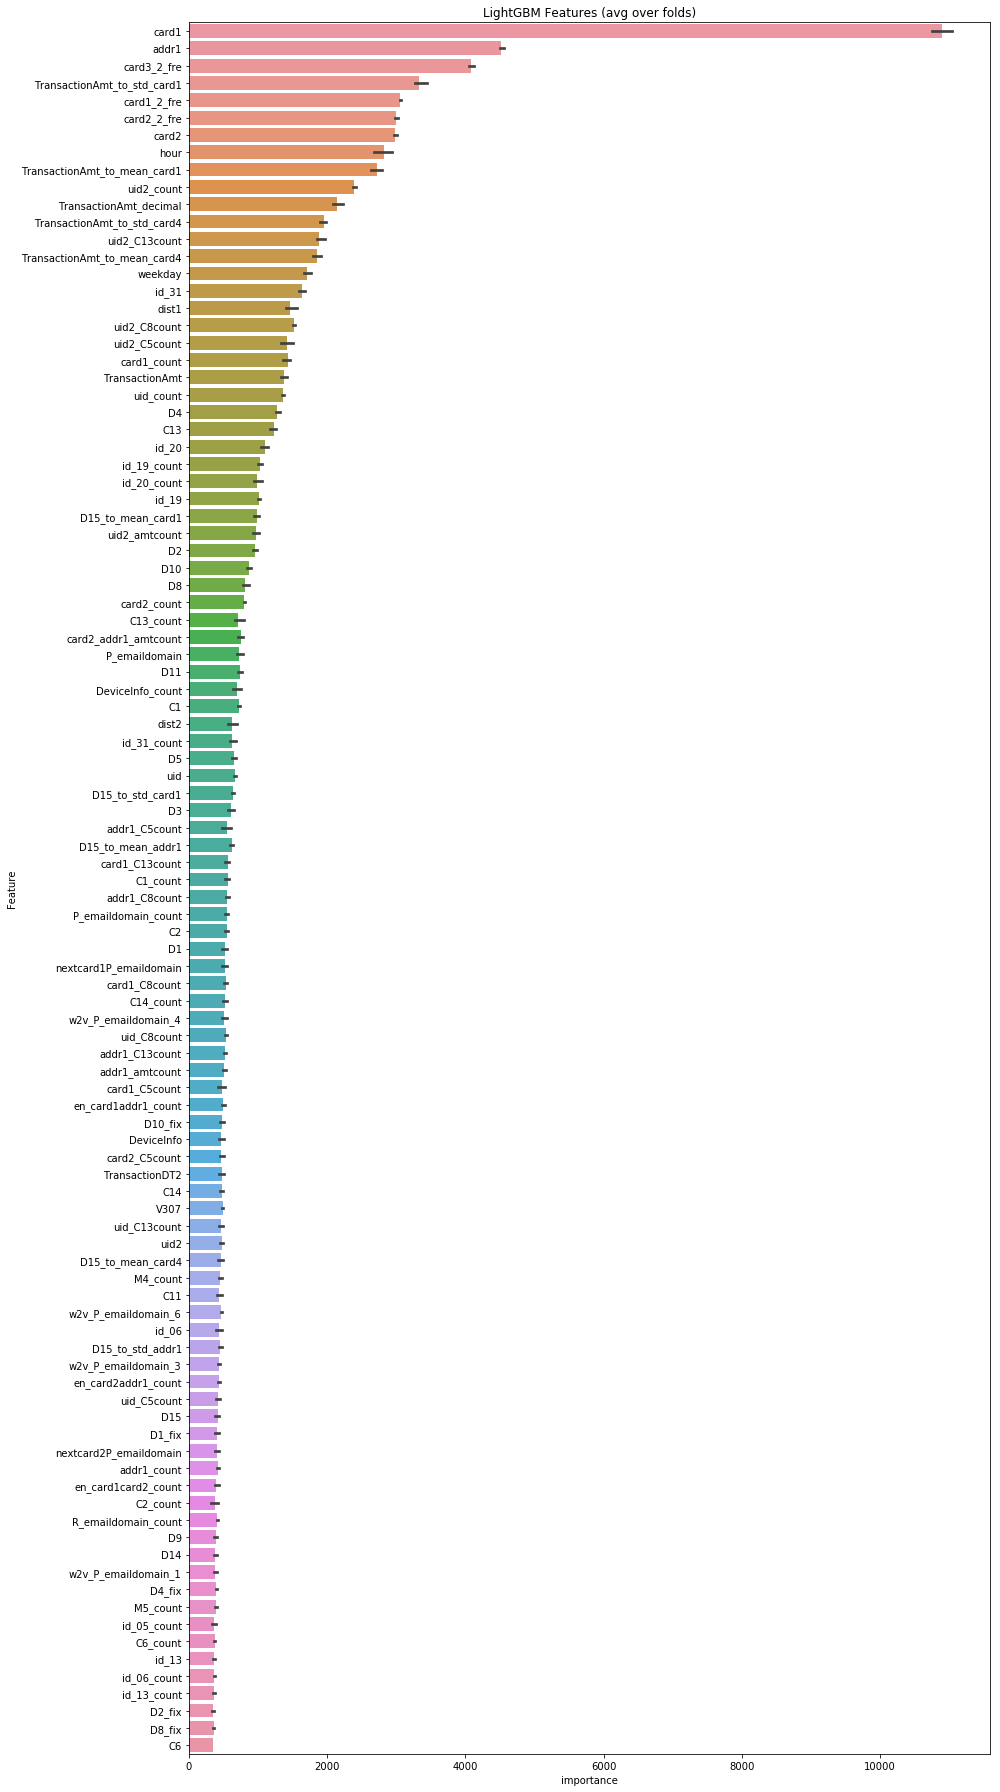

In [28]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[-100:].index)
print(cols)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [29]:
import catboost as cb
from catboost import CatBoostClassifier,Pool

# os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

features = [x for x in X_train.columns if (x not in col_del ) and  not x.startswith("w2v")]
print(len(features))
cate = [x for x in features if (x == 'ProductCD' or x in ['card1','card2','uid','uid2'] or  x.startswith("addr") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" 
       and x not in train_f6.columns]

# cate = []
print(cate)
verbose_eval = 30
num_rounds = 700
y_preds3_temp = np.zeros(X_test.shape[0])
y_preds3_temp2 = np.zeros(X_test.shape[0])

folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
y_preds3 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :].fillna(-999), X_train[features].iloc[val_idx, :].fillna(-999)
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    model=cb.CatBoostClassifier(iterations=num_rounds,depth=15,learning_rate=0.04,loss_function='Logloss',eval_metric='Logloss'
                                ,min_data_in_leaf=15,l2_leaf_reg=3.0
                                ,task_type = "GPU",devices = ["1"]
                               )
    if debug:
#         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_test[features].fillna(-999), y_test),verbose_eval = 30)
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    else:
#         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_vl[features], y_vl),verbose_eval = 30)
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    best_iter = model.get_best_iteration()
    best_iter = 0
    print(best_iter)
    y_pred_train = model.predict_proba(X_vl,ntree_end = best_iter)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp =  model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] 
    y_preds3 += temp/ folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))
        best_iter = num_rounds - 100
        y_preds3_temp += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
        best_iter = num_rounds - 200
        y_preds3_temp2 += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33))

521
['ProductCD', 'card1', 'card2', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'uid', 'uid2', 'nextcard1P_emaildomain', 'nextcard2P_emaildomain', 'DeviceType', 'DeviceInfo']
0:	learn: 0.6147280	total: 1.35s	remaining: 15m 46s
30:	learn: 0.0843575	total: 41.9s	remaining: 15m 3s
60:	learn: 0.0615691	total: 1m 23s	remaining: 14m 30s
90:	learn: 0.0523398	total: 2m 5s	remaining: 13m 58s
120:	learn: 0.0469337	total: 2m 46s	remaining: 13m 18s
150:	learn: 0.0433641	total: 3m 28s	remaining: 12m 37s
180:	learn: 0.0406815	total: 4m 8s	remaining: 11m 53s
210:	learn: 0.0388703	total: 4m 49s	remaining: 11m 10s
240:	learn: 0.0370999	total: 5m 30s	remaining: 10m 28s
270:	learn: 0.0356860	total: 6m 10s	remaining: 9m 46s
300:	learn: 0.0345173	total: 6m 50s	remaining: 9m 4s
330:	learn: 0.0329197	total: 7m 31s	remaining: 8m 23s
360:	learn: 0.0316822	total: 8m 11s	remaining: 7m 41s
390:	learn: 0.0304212	total: 8m 52s	remaining: 7m
420:	learn: 0.0293002	total: 9m 32s	remaining: 6m 19s
450:	learn: 0

In [30]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0))


debug: 0.9379478107393002 0.08430458773462242
debug: 0.9249585850205073 0.0977999910416544
debug: 0.9255790070802897 0.0921372398128494
debug: 0.9387454463113697 0.08333475266689964
debug: 0.9401239462383216 0.08269743300927283
debug: 0.9412710657400639 0.08118774348784064
debug: 0.9413590575760648 0.08256753641083586


In [31]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*1.5 + y_preds*1.5 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*1.4 + y_preds*1.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/5))
    

debug: 0.9379478107393002 0.08430458773462242
debug: 0.9249585850205073 0.0977999910416544
debug: 0.9255790070802897 0.0921372398128494
debug: 0.9387454463113697 0.08333475266689964
debug: 0.9401239462383216 0.08269743300927283
debug: 0.9412710657400639 0.08532262380300398
debug: 0.9415100129194507 0.08085277876137083


In [32]:
if debug:
    X_test_pred = pd.DataFrame(index = X_test.index)
    X_test_pred['y_pred'] = y_preds
    X_test_pred['y_pred11'] = y_preds11
    X_test_pred['y_preds2'] = y_preds2
    X_test_pred['y_preds22'] = y_preds22
    X_test_pred['y_preds3'] = y_preds3
    X_test_pred['true'] = y_test
    X_test_pred.to_csv('simple_offline16.csv')
else:
    sample_submission['isFraud'] =  (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)/2.5
    sample_submission['isFraud'] =  (y_preds11*1.4 + y_preds*1.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/5
    sample_submission.to_csv('simple_ensemble16.csv')
